In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from geopy.distance import geodesic
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/cleaned-oncologist-data/all_oncologists.csv
/kaggle/input/yelp-reviews-sentiment-scores/final_combined_yelp_data.csv
/kaggle/input/dac-sentiment-scores/DAC_scored.csv
/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.shp
/kaggle/input/us-doctors-and-clinicians-2021/DAC_NationalDownloadableFile.csv
/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.shx
/kaggle/input/us-doctors-and-clinicians-2021/physicians-by-specialty-and-patient-care-hours.csv
/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.prj
/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.shp.ea.iso.xml
/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.cpg
/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.dbf
/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.shp.iso.xml


# Load in data

The cleaned oncologist data is the output from the EDA, which includes MDs and DOs that practice oncology as one of their 5 specialties. Information such as latitude and longitude of their practice address, the coordinates of the center (centroid) zip code of that address, and the full name and address.

Centroids were calculated in order to determine distance measurements, which is an important feature of our recommendation system.

The Yelp reviews contain sentiment scores determined by using VADER models.

In [2]:
cleaned_oncologists_df = pd.read_csv('/kaggle/input/cleaned-oncologist-data/all_oncologists.csv')
cleaned_oncologists_df

/tmp/ipykernel_32/3687665596.py:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_oncologists_df = pd.read_csv('/kaggle/input/cleaned-oncologist-data/all_oncologists.csv')


,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,ind_assgn,grp_assgn,adrs_id,full_name,full_address,latitude,longitude,centroid_latitude,centroid_longitude,distance_from_center_zip
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,Y,Y,MT591010905BI801XXSTXX400,"SWANEY, ROBERT","801 N 29TH ST, BILLINGS, MT 59101",45.787789,-108.512586,45.613054,-108.390305,0.213273
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,Y,Y,IN476308909NE3699XRDXX300,"SWANEY, ROBERT","3699 EPWORTH RD, NEWBURGH, IN 47630",37.981127,-87.442704,37.952897,-87.346470,0.100289
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,Y,Y,FL331762118MI8900XDRXX400,"GIRON, GLADYS L","8900 N KENDALL DR, MIAMI, FL 33176",25.683594,-80.338203,25.659878,-80.358354,0.031121
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,Y,Y,OH452362725CI4777XRDXX402,"MOSBACHER, MARC R","4777 E GALBRAITH RD SUITE 1, CINCINNATI, OH 45236",39.205869,-84.381013,39.209810,-84.397302,0.016759
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,Y,Y,IN465142450EL1215XAVEX303,"JOHNSON, RUSSELL FREDERICK","1215 LAWN AVE SUITE 120, ELKHART, IN 46514",41.679288,-85.993260,41.722703,-85.977009,0.046357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16517,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,Y,Y,NY100219800NE520XXSTXX409,"LEONARD, JOHN P","520 E 70TH ST SUITE 651, NEW YORK, NY 10021",40.765090,-73.953755,40.769224,-73.958741,0.006477
16518,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,Y,Y,NY100654870NE525XXSTXX400,"LEONARD, JOHN P","525 E 68TH ST, NEW YORK, NY 10065",40.764777,-73.954801,40.764628,-73.963144,0.008344
16519,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,Y,Y,NY100654870NE525XXSTXX406,"LEONARD, JOHN P","525 E 68TH ST M6, NEW YORK, NY 10065",40.764301,-73.954280,40.764628,-73.963144,0.008870
16520,1992895510,9931113818,I20060131000088,SHAMI,PAUL,J,NaN,M,MD,OTHER,...,Y,Y,UT841125500SA1950XDRXX500,"SHAMI, PAUL J","1950 CIRCLE OF HOPE DR, SALT LAKE CITY, UT 84112",40.773364,-111.834893,40.765076,-111.841478,0.010585


In [3]:
cleaned_oncologists_df.dtypes

NPI                           int64
Ind_PAC_ID                    int64
Ind_enrl_ID                  object
lst_nm                       object
frst_nm                      object
mid_nm                       object
suff                         object
gndr                         object
Cred                         object
Med_sch                      object
Grd_yr                      float64
pri_spec                     object
sec_spec_1                   object
sec_spec_2                   object
sec_spec_3                   object
sec_spec_4                   object
sec_spec_all                 object
Telehlth                     object
org_nm                       object
org_pac_id                  float64
num_org_mem                 float64
adr_ln_1                     object
adr_ln_2                     object
ln_2_sprs                    object
cty                          object
st                           object
zip                           int64
phn_numbr                   

In [4]:
cleaned_oncologists_df['org_nm'].value_counts()

UNIVERSITY OF MIAMI                                       510
TEXAS ONCOLOGY PA                                         470
REGENTS OF THE UNIVERSITY OF MICHIGAN                     426
PHYSICIANS REFERRAL SERVICE                               319
FLORIDA CANCER SPECIALISTS AND RESEARCH INSTITUTE, LLC    225
                                                         ... 
UROLOGY PARTNERS LLC                                        1
PHOENIXVILLE CLINIC COMPANY LLC                             1
RIVER VALLEY PHYSICIANS LLC                                 1
COFFEYVILLE REGIONAL MEDICAL CENTER INC                     1
ST JAMES HOSPITAL                                           1
Name: org_nm, Length: 1962, dtype: int64

In [5]:
# Replace NaN with 'UNKNOWN'
cleaned_oncologists_df['org_nm'].fillna('UNKNOWN', inplace=True)

In [6]:
scored_dac_df = pd.read_csv('/kaggle/input/dac-sentiment-scores/DAC_scored.csv')
scored_dac_df.head()

/tmp/ipykernel_32/1328853226.py:1: DtypeWarning: Columns (15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  scored_dac_df = pd.read_csv('/kaggle/input/dac-sentiment-scores/DAC_scored.csv')


,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,st,zip,phn_numbr,ind_assgn,grp_assgn,adrs_id,FULLNAME,positive,negative,compound
0,1.003000e+09,7.517004e+09,I20130530000085,ENKESHAFI,ARDALAN,NaN,NaN,M,NaN,OTHER,...,MD,207745477,2.406771e+09,Y,Y,MD207745477LA901XXDRXX500,ARDALAN-ENKESHAFI,NaN,NaN,NaN
1,1.003000e+09,7.517004e+09,I20130530000085,ENKESHAFI,ARDALAN,NaN,NaN,M,NaN,OTHER,...,VA,201903204,2.406862e+09,Y,Y,VA201903204RE1850XPKWY400,ARDALAN-ENKESHAFI,NaN,NaN,NaN
2,1.003000e+09,7.517004e+09,I20130530000085,ENKESHAFI,ARDALAN,NaN,NaN,M,NaN,OTHER,...,VA,222053610,7.035586e+09,Y,Y,VA222053610AR1701XDRXX500,ARDALAN-ENKESHAFI,NaN,NaN,NaN
3,1.003000e+09,7.517004e+09,I20130530000085,ENKESHAFI,ARDALAN,NaN,NaN,M,NaN,OTHER,...,MD,207075255,3.016045e+09,Y,Y,MD207075255LA14207DRXX402,ARDALAN-ENKESHAFI,NaN,NaN,NaN
4,1.003000e+09,7.517004e+09,I20130530000085,ENKESHAFI,ARDALAN,NaN,NaN,M,NaN,OTHER,...,MD,208141422,NaN,Y,Y,MD208141422BE8600XRDXX400,ARDALAN-ENKESHAFI,NaN,NaN,NaN


In [7]:
scored_dac_df.dtypes

NPI             float64
Ind_PAC_ID      float64
Ind_enrl_ID      object
lst_nm           object
frst_nm          object
mid_nm           object
suff             object
gndr             object
Cred             object
Med_sch          object
Grd_yr          float64
pri_spec         object
sec_spec_1       object
sec_spec_2       object
sec_spec_3       object
sec_spec_4       object
sec_spec_all     object
Telehlth         object
org_nm           object
org_pac_id      float64
num_org_mem     float64
adr_ln_1         object
adr_ln_2         object
ln_2_sprs        object
cty              object
st               object
zip              object
phn_numbr       float64
ind_assgn        object
grp_assgn        object
adrs_id          object
FULLNAME         object
positive        float64
negative        float64
compound        float64
dtype: object

In [8]:
scored_dac_df['org_nm'].value_counts()

UNIVERSITY OF MIAMI                                33128
REGENTS OF THE UNIVERSITY OF MICHIGAN              27755
SOUTHERN CALIFORNIA PERMANENTE MEDICAL GROUP       17323
NORTH SHORE - LIJ MEDICAL PC                       14721
UNIVERSITY OF PITTSBURGH PHYSICIANS                12473
                                                   ...  
ABRAHAM ALBOHER O.D. PC                                2
HEART OF BOARDWALK                                     2
FS OPTOMETRY LLC                                       2
NEXT LEVEL PHYSICAL THERAPY AND PERFORMANCE INC        2
CAPITAL INTERNAL MEDICINE AND GERIATRICS LLC           2
Name: org_nm, Length: 75513, dtype: int64

In [9]:
raw_zip_df = gpd.read_file('/kaggle/input/us-doctors-and-clinicians-2021/tl_2019_us_zcta510.shp')
raw_zip_df

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.70873 41.32733, -83.70815 41.327..."
1,43452,43452,B5,G6350,S,121522304,13721730,+41.5157923,-082.9809454,"POLYGON ((-83.08698 41.53780, -83.08256 41.537..."
2,43456,43456,B5,G6350,S,9320975,1003775,+41.6318300,-082.8393923,"MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ..."
3,43457,43457,B5,G6350,S,48004681,0,+41.2673301,-083.4274872,"POLYGON ((-83.49650 41.25371, -83.48382 41.253..."
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.22229 41.53102, -83.22228 41.532..."
...,...,...,...,...,...,...,...,...,...,...
33139,84044,84044,B5,G6350,S,123283611,69912363,+40.7201095,-112.1549645,"POLYGON ((-112.26022 40.76909, -112.25333 40.7..."
33140,84045,84045,B5,G6350,S,52780589,105248,+40.3364908,-111.9111905,"MULTIPOLYGON (((-111.92421 40.17034, -111.9240..."
33141,84046,84046,B5,G6350,S,333205012,4460752,+40.9207693,-109.8310453,"POLYGON ((-110.00072 40.99745, -110.00036 40.9..."
33142,84047,84047,B5,G6350,S,16172461,0,+40.6152301,-111.8907499,"POLYGON ((-111.92141 40.62772, -111.92134 40.6..."


In [10]:
# rename and format columns
zip_codes_df = raw_zip_df.loc[:, ['ZCTA5CE10','INTPTLAT10','INTPTLON10']]
zip_codes_df = zip_codes_df.rename(columns={'ZCTA5CE10':'Zip',
                                            'INTPTLAT10':'Centroid Latitude',
                                            'INTPTLON10':'Centroid Longitude'})
zip_codes_df['Zip'] = zip_codes_df['Zip'].astype(int)
zip_codes_df['Centroid Latitude'] = zip_codes_df['Centroid Latitude'].astype(float)
zip_codes_df['Centroid Longitude'] = zip_codes_df['Centroid Longitude'].astype(float)

zip_codes_df

,Zip,Centroid Latitude,Centroid Longitude
0,43451,41.318301,-83.617493
1,43452,41.515792,-82.980945
2,43456,41.631830,-82.839392
3,43457,41.267330,-83.427487
4,43458,41.530446,-83.213365
...,...,...,...
33139,84044,40.720109,-112.154965
33140,84045,40.336491,-111.911191
33141,84046,40.920769,-109.831045
33142,84047,40.615230,-111.890750


In [11]:
zip_codes_df.to_csv('/kaggle/working/zip_codes_centroids.csv', index=False)

In [12]:
zip_codes_df.dtypes

Zip                     int64
Centroid Latitude     float64
Centroid Longitude    float64
dtype: object

In [13]:
reviews_df = pd.read_csv('/kaggle/input/yelp-reviews-sentiment-scores/final_combined_yelp_data.csv')
reviews_df.head()

,business_id,positive,negative,neutral,compound,business_name,name,address,city,state,postal_code,latitude,longitude,categories
0,--7jw19RH9JKXgFohspgQw,0.379000,0.0330,0.588000,0.991700,mcilwain-family-dentistry-and-ahrens-orthodont...,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 Foggy Creek Rd, Ste 101",Wesley Chapel,FL,33544,28.189156,-82.371421,"Orthodontists, Health & Medical, General Denti..."
1,--7jw19RH9JKXgFohspgQw,0.379000,0.0330,0.588000,0.991700,mcilwain-family-dentistry-and-ahrens-orthodont...,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 Foggy Creek Rd, Ste 101",Wesley Chapel,FL,33544,28.189156,-82.371421,"Orthodontists, Health & Medical, General Denti..."
2,--Sd93OFWITqDHifMoAy9g,0.062000,0.0650,0.873000,-0.426900,proactive-physical-therapy-tucson-22,ProActive Physical Therapy,"8770 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.365670,-111.046134,"Physical Therapy, Health & Medical, Fitness & ..."
3,--Sd93OFWITqDHifMoAy9g,0.062000,0.0650,0.873000,-0.426900,proactive-physical-therapy-tucson-22,ProActive Physical Therapy,"8770 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.365670,-111.046134,"Physical Therapy, Health & Medical, Fitness & ..."
4,-02xFuruu85XmDn2xiynJw,0.222435,0.0325,0.745022,0.792376,family-vision-source-tucson,Family Vision Center,7475 E Tanque Verde Rd,Tucson,AZ,85715,32.251039,-110.833173,"Shopping, Ophthalmologists, Optometrists, Doct..."


In [14]:
reviews_df['compound'].value_counts()

 0.963200    15
 0.977800    15
 0.988600    14
 0.984300    14
 0.989400    13
             ..
 0.958650     1
-0.179567     1
 0.260744     1
 0.818600     1
 0.721175     1
Name: compound, Length: 6977, dtype: int64

In [15]:
# Count NaN values in 'compound'
nan_count = reviews_df['compound'].isna().sum()
print("Number of NaN values in 'compound':", nan_count)

Number of NaN values in 'compound': 0


In [16]:
# create a full address column
reviews_df['full_address'] = reviews_df['address'].str.upper() + ', ' + reviews_df['city'].str.upper() + ', ' + reviews_df['state'] + ' ' + reviews_df['postal_code'].astype(str)

# remove any spaces before the comma
reviews_df['full_address'] = reviews_df['full_address'].str.replace(' ,', ',')

reviews_df.head()

,business_id,positive,negative,neutral,compound,business_name,name,address,city,state,postal_code,latitude,longitude,categories,full_address
0,--7jw19RH9JKXgFohspgQw,0.379000,0.0330,0.588000,0.991700,mcilwain-family-dentistry-and-ahrens-orthodont...,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 Foggy Creek Rd, Ste 101",Wesley Chapel,FL,33544,28.189156,-82.371421,"Orthodontists, Health & Medical, General Denti...","26908 FOGGY CREEK RD, STE 101, WESLEY CHAPEL, ..."
1,--7jw19RH9JKXgFohspgQw,0.379000,0.0330,0.588000,0.991700,mcilwain-family-dentistry-and-ahrens-orthodont...,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 Foggy Creek Rd, Ste 101",Wesley Chapel,FL,33544,28.189156,-82.371421,"Orthodontists, Health & Medical, General Denti...","26908 FOGGY CREEK RD, STE 101, WESLEY CHAPEL, ..."
2,--Sd93OFWITqDHifMoAy9g,0.062000,0.0650,0.873000,-0.426900,proactive-physical-therapy-tucson-22,ProActive Physical Therapy,"8770 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.365670,-111.046134,"Physical Therapy, Health & Medical, Fitness & ...","8770 N THORNYDALE RD, STE 100, TUCSON, AZ 85742"
3,--Sd93OFWITqDHifMoAy9g,0.062000,0.0650,0.873000,-0.426900,proactive-physical-therapy-tucson-22,ProActive Physical Therapy,"8770 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.365670,-111.046134,"Physical Therapy, Health & Medical, Fitness & ...","8770 N THORNYDALE RD, STE 100, TUCSON, AZ 85742"
4,-02xFuruu85XmDn2xiynJw,0.222435,0.0325,0.745022,0.792376,family-vision-source-tucson,Family Vision Center,7475 E Tanque Verde Rd,Tucson,AZ,85715,32.251039,-110.833173,"Shopping, Ophthalmologists, Optometrists, Doct...","7475 E TANQUE VERDE RD, TUCSON, AZ 85715"


In [17]:
# standardize street address abbreviations
street_mapping = {
    'Alley': 'ALY',
    'Avenue': 'AVE',
    'Boulevard': 'BLVD',
    'Causeway': 'CSWY',
    'Center': 'CTR',
    'Circle': 'CIR',
    'Court': 'CT',
    'Cove': 'CV',
    'Crossing': 'XING',
    'Drive': 'DR',
    'Expressway': 'EXPY',
    'Extension': 'EXT',
    'Freeway': 'FWY',
    'Grove': 'GRV',
    'Highway': 'HWY',
    'Hollow': 'HOLW',
    'Junction': 'JCT',
    'Lane': 'LN',
    'Motorway': 'MTWY',
    'Overpass': 'OPAS',
    'Park': 'PARK',
    'Parkway': 'PKWY',
    'Place': 'PL',
    'Plaza': 'PLZ',
    'Point': 'PT',
    'Road': 'RD',
    'Route': 'RTE',
    'Skyway': 'SKWY',
    'Square': 'SQ',
    'Street': 'ST',
    'Terrace': 'TER',
    'Trail': 'TRL',
    'Way': 'WAY'
}

# Convert the keys in the suffix_mapping dictionary to uppercase
street_mapping = {key.upper(): value for key, value in street_mapping.items()}

# Replace street suffixes in the 'Address' column with their abbreviated forms
reviews_df['full_address'] = reviews_df['full_address'].replace(street_mapping, regex=True)
cleaned_oncologists_df['full_address'] = cleaned_oncologists_df['full_address'].replace(street_mapping, regex=True)

In [18]:
secondary_mapping = {
    'Apartment': 'APT',
    'Basement': 'BSMT',
    'Blank, unable to determine': '',
    'Building': 'BLDG',
    'Department': 'DEPT',
    'Floor': 'FL',
    'Front': 'FRNT',
    'Hanger': 'HNGR',
    'Key': 'KEY',
    'Lobby': 'LBBY',
    'Lot': 'LOT',
    'Lower': 'LOWR',
    'Office': 'OFC',
    'Penthouse': 'PH',
    'Pier': 'PIER',
    'Rear': 'REAR',
    'Room': 'RM',
    'Side': 'SIDE',
    'Slip': 'SLIP',
    'Space': 'SPC',
    'Stop': 'STOP',
    'Suite': 'STE',
    'Trailer': 'TRLR',
    'Unit': 'UNIT',
    'Upper': 'UPPR'
}

# Convert the keys in the suffix_mapping dictionary to uppercase
secondary_mapping = {key.upper(): value for key, value in secondary_mapping.items()}

# Replace street suffixes in the 'Address' column with their abbreviated forms
reviews_df['full_address'] = reviews_df['full_address'].replace(secondary_mapping, regex=True)
cleaned_oncologists_df['full_address'] = cleaned_oncologists_df['full_address'].replace(secondary_mapping, regex=True)

In [19]:
directional_mapping = {
    'North': 'N',
    'South': 'S',
    'East': 'E',
    'West': 'W',
    'Northeast': 'NE',
    'North East': 'NE',
    'Northwest': 'NW',
    'North West': 'NW',
    'Southeast': 'SE',
    'South East': 'SE',
    'Southwest': 'SW',
    'South West': 'SW'
}

# Convert the keys in the suffix_mapping dictionary to uppercase
directional_mapping = {key.upper(): value for key, value in directional_mapping.items()}

# Replace street suffixes in the 'Address' column with their abbreviated forms
reviews_df['full_address'] = reviews_df['full_address'].replace(directional_mapping, regex=True)
cleaned_oncologists_df['full_address'] = cleaned_oncologists_df['full_address'].replace(directional_mapping, regex=True)

In [20]:
# check for 'AVENUE' to see if mapping was successful
reviews_df = reviews_df[reviews_df['full_address'].notna()]
reviews_df[reviews_df['full_address'].str.contains('AVENUE', case=False)]

,business_id,positive,negative,neutral,compound,business_name,name,address,city,state,postal_code,latitude,longitude,categories,full_address


In [21]:
# check for 'AVENUE' to see if mapping was successful
cleaned_oncologists_df = cleaned_oncologists_df[cleaned_oncologists_df['full_address'].notna()]
cleaned_oncologists_df[cleaned_oncologists_df['full_address'].str.contains('AVENUE', case=False)]

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,ind_assgn,grp_assgn,adrs_id,full_name,full_address,latitude,longitude,centroid_latitude,centroid_longitude,distance_from_center_zip


In [22]:
# check for 'SUITE' to see if mapping was successful
reviews_df = reviews_df[reviews_df['full_address'].notna()]
reviews_df[reviews_df['full_address'].str.contains('SUITE', case=False)]

,business_id,positive,negative,neutral,compound,business_name,name,address,city,state,postal_code,latitude,longitude,categories,full_address


In [23]:
# check for 'SUITE' to see if mapping was successful
cleaned_oncologists_df = cleaned_oncologists_df[cleaned_oncologists_df['full_address'].notna()]
cleaned_oncologists_df[cleaned_oncologists_df['full_address'].str.contains('SUITE', case=False)]

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,ind_assgn,grp_assgn,adrs_id,full_name,full_address,latitude,longitude,centroid_latitude,centroid_longitude,distance_from_center_zip


In [24]:
# select specific columns by name
selected_columns = ['business_id','compound','name','full_address','latitude','longitude']
reviews_df = reviews_df[selected_columns]

# create a dictionary to map old column names to new column names
new_column_names = {
    'business_id': 'Business ID',
    'compound': 'Business Compound Score',
    'name': 'Practice Name'
}

# rename the columns using the dictionary
reviews_df = reviews_df.rename(columns=new_column_names)
reviews_df.head()

,Business ID,Business Compound Score,Practice Name,full_address,latitude,longitude
0,--7jw19RH9JKXgFohspgQw,0.991700,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 FOGGY CREEK RD, STE 101, WESLEY CHAPEL, ...",28.189156,-82.371421
1,--7jw19RH9JKXgFohspgQw,0.991700,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 FOGGY CREEK RD, STE 101, WESLEY CHAPEL, ...",28.189156,-82.371421
2,--Sd93OFWITqDHifMoAy9g,-0.426900,ProActive Physical Therapy,"8770 N THORNYDALE RD, STE 100, TUCSON, AZ 85742",32.365670,-111.046134
3,--Sd93OFWITqDHifMoAy9g,-0.426900,ProActive Physical Therapy,"8770 N THORNYDALE RD, STE 100, TUCSON, AZ 85742",32.365670,-111.046134
4,-02xFuruu85XmDn2xiynJw,0.792376,Family Vision Center,"7475 E TANQUE VERDE RD, TUCSON, AZ 85715",32.251039,-110.833173


## Calculate distances in miles

In [25]:
# drop any coordinates with NaN

# dount rows before dropping
rows_before = len(cleaned_oncologists_df)

# drop rows with NaN values in columns 'A' and 'B'
cleaned_oncologists_df = cleaned_oncologists_df.dropna(subset=['latitude','longitude','centroid_latitude','centroid_longitude'])

# count rows after dropping
rows_after = len(cleaned_oncologists_df)

# calculate the number of dropped rows
rows_dropped = rows_before - rows_after

# display the DataFrame and the number of dropped rows
print("Dropped Rows:", rows_dropped)
cleaned_oncologists_df

Dropped Rows: 643


,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,ind_assgn,grp_assgn,adrs_id,full_name,full_address,latitude,longitude,centroid_latitude,centroid_longitude,distance_from_center_zip
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,Y,Y,MT591010905BI801XXSTXX400,"SWANEY, ROBERT","801 N 29TH ST, BILLINGS, MT 59101",45.787789,-108.512586,45.613054,-108.390305,0.213273
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,Y,Y,IN476308909NE3699XRDXX300,"SWANEY, ROBERT","3699 EPWORTH RD, NEWBURGH, IN 47630",37.981127,-87.442704,37.952897,-87.346470,0.100289
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,Y,Y,FL331762118MI8900XDRXX400,"GIRON, GLADYS L","8900 N KENDALL DR, MIAMI, FL 33176",25.683594,-80.338203,25.659878,-80.358354,0.031121
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,Y,Y,OH452362725CI4777XRDXX402,"MOSBACHER, MARC R","4777 E GALBRAITH RD STE 1, CINCINNATI, OH 45236",39.205869,-84.381013,39.209810,-84.397302,0.016759
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,Y,Y,IN465142450EL1215XAVEX303,"JOHNSON, RUSSELL FREDERICK","1215 LAWN AVE STE 120, ELKHART, IN 46514",41.679288,-85.993260,41.722703,-85.977009,0.046357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16517,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,Y,Y,NY100219800NE520XXSTXX409,"LEONARD, JOHN P","520 E 70TH ST STE 651, NEW YORK, NY 10021",40.765090,-73.953755,40.769224,-73.958741,0.006477
16518,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,Y,Y,NY100654870NE525XXSTXX400,"LEONARD, JOHN P","525 E 68TH ST, NEW YORK, NY 10065",40.764777,-73.954801,40.764628,-73.963144,0.008344
16519,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,Y,Y,NY100654870NE525XXSTXX406,"LEONARD, JOHN P","525 E 68TH ST M6, NEW YORK, NY 10065",40.764301,-73.954280,40.764628,-73.963144,0.008870
16520,1992895510,9931113818,I20060131000088,SHAMI,PAUL,J,NaN,M,MD,OTHER,...,Y,Y,UT841125500SA1950XDRXX500,"SHAMI, PAUL J","1950 CIR OF HOPE DR, SALT LAKE CITY, UT 84112",40.773364,-111.834893,40.765076,-111.841478,0.010585


In [26]:
# define Earth's radius in miles
earth_radius_miles = 3958.8

# Function to calculate distance between two points using haversine formula
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).miles

# Calculate the distances and store them in a new column
cleaned_oncologists_df.loc[:, 'distance_miles_from_center_zip'] = cleaned_oncologists_df.apply(
    lambda row: calculate_distance(row['latitude'], row['longitude'],
                                   row['centroid_latitude'], row['centroid_longitude']),
    axis=1
)

In [27]:
cleaned_oncologists_df.head()

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,grp_assgn,adrs_id,full_name,full_address,latitude,longitude,centroid_latitude,centroid_longitude,distance_from_center_zip,distance_miles_from_center_zip
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,Y,MT591010905BI801XXSTXX400,"SWANEY, ROBERT","801 N 29TH ST, BILLINGS, MT 59101",45.787789,-108.512586,45.613054,-108.390305,0.213273,13.440452
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,Y,IN476308909NE3699XRDXX300,"SWANEY, ROBERT","3699 EPWORTH RD, NEWBURGH, IN 47630",37.981127,-87.442704,37.952897,-87.346470,0.100289,5.603618
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,Y,FL331762118MI8900XDRXX400,"GIRON, GLADYS L","8900 N KENDALL DR, MIAMI, FL 33176",25.683594,-80.338203,25.659878,-80.358354,0.031121,2.060475
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,Y,OH452362725CI4777XRDXX402,"MOSBACHER, MARC R","4777 E GALBRAITH RD STE 1, CINCINNATI, OH 45236",39.205869,-84.381013,39.209810,-84.397302,0.016759,0.915514
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,Y,IN465142450EL1215XAVEX303,"JOHNSON, RUSSELL FREDERICK","1215 LAWN AVE STE 120, ELKHART, IN 46514",41.679288,-85.993260,41.722703,-85.977009,0.046357,3.111896


## Calculate years of experience

In [28]:
# Fill in missing values with 'unknown'
cleaned_oncologists_df['Grd_yr'].fillna('unknown')

# Calculate today's year
current_year = datetime.date.today().year

# Calculate years of experience
cleaned_oncologists_df['years_of_experience'] = current_year - cleaned_oncologists_df['Grd_yr']

cleaned_oncologists_df

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,adrs_id,full_name,full_address,latitude,longitude,centroid_latitude,centroid_longitude,distance_from_center_zip,distance_miles_from_center_zip,years_of_experience
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,MT591010905BI801XXSTXX400,"SWANEY, ROBERT","801 N 29TH ST, BILLINGS, MT 59101",45.787789,-108.512586,45.613054,-108.390305,0.213273,13.440452,34.0
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,IN476308909NE3699XRDXX300,"SWANEY, ROBERT","3699 EPWORTH RD, NEWBURGH, IN 47630",37.981127,-87.442704,37.952897,-87.346470,0.100289,5.603618,34.0
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,FL331762118MI8900XDRXX400,"GIRON, GLADYS L","8900 N KENDALL DR, MIAMI, FL 33176",25.683594,-80.338203,25.659878,-80.358354,0.031121,2.060475,28.0
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,OH452362725CI4777XRDXX402,"MOSBACHER, MARC R","4777 E GALBRAITH RD STE 1, CINCINNATI, OH 45236",39.205869,-84.381013,39.209810,-84.397302,0.016759,0.915514,26.0
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,IN465142450EL1215XAVEX303,"JOHNSON, RUSSELL FREDERICK","1215 LAWN AVE STE 120, ELKHART, IN 46514",41.679288,-85.993260,41.722703,-85.977009,0.046357,3.111896,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16517,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NY100219800NE520XXSTXX409,"LEONARD, JOHN P","520 E 70TH ST STE 651, NEW YORK, NY 10021",40.765090,-73.953755,40.769224,-73.958741,0.006477,0.387038,33.0
16518,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NY100654870NE525XXSTXX400,"LEONARD, JOHN P","525 E 68TH ST, NEW YORK, NY 10065",40.764777,-73.954801,40.764628,-73.963144,0.008344,0.437838,33.0
16519,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NY100654870NE525XXSTXX406,"LEONARD, JOHN P","525 E 68TH ST M6, NEW YORK, NY 10065",40.764301,-73.954280,40.764628,-73.963144,0.008870,0.465603,33.0
16520,1992895510,9931113818,I20060131000088,SHAMI,PAUL,J,NaN,M,MD,OTHER,...,UT841125500SA1950XDRXX500,"SHAMI, PAUL J","1950 CIR OF HOPE DR, SALT LAKE CITY, UT 84112",40.773364,-111.834893,40.765076,-111.841478,0.010585,0.668106,35.0


## Adjust coordinates to 2 significant figures
The coordinates do not match up exactly between the DAC dataset and the Yelp dataset. Create a new coordinate for the practice location for merging.

In [29]:
# there seems to be some rounding errors when dealing with floats (with respect to the practice coordinates)
def convert_float_to_string(x, decimal_places=2):
    string = str(x)
    first = string.split('.')[0]
    second = string.split('.')[1][:decimal_places]
    return f'{first}.{second}'

In [30]:
convert_float_to_string(cleaned_oncologists_df.iloc[0,-5], 3)

'45.613'

In [31]:
# create new coordinate for practice location
coord_precision = 2

# convert to string then drop to 2 decimal places
# cleaned_oncologists_df['practice_latitude'] = cleaned_oncologists_df['latitude']

cleaned_oncologists_df['practice_latitude'] = cleaned_oncologists_df['latitude'].apply(lambda x: convert_float_to_string(x, 2))
cleaned_oncologists_df['practice_longitude'] = cleaned_oncologists_df['longitude'].apply(lambda x: convert_float_to_string(x, 2))
reviews_df['practice_latitude'] = reviews_df['latitude'].apply(lambda x: convert_float_to_string(x, 2))
reviews_df['practice_longitude'] = reviews_df['longitude'].apply(lambda x: convert_float_to_string(x, 2))

## Join datasets

Combine the yelp reviews dataset with the doctors and clinicians dataset

In [32]:
cleaned_oncologists_df.head()

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,full_address,latitude,longitude,centroid_latitude,centroid_longitude,distance_from_center_zip,distance_miles_from_center_zip,years_of_experience,practice_latitude,practice_longitude
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,"801 N 29TH ST, BILLINGS, MT 59101",45.787789,-108.512586,45.613054,-108.390305,0.213273,13.440452,34.0,45.78,-108.51
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,"3699 EPWORTH RD, NEWBURGH, IN 47630",37.981127,-87.442704,37.952897,-87.346470,0.100289,5.603618,34.0,37.98,-87.44
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,"8900 N KENDALL DR, MIAMI, FL 33176",25.683594,-80.338203,25.659878,-80.358354,0.031121,2.060475,28.0,25.68,-80.33
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,"4777 E GALBRAITH RD STE 1, CINCINNATI, OH 45236",39.205869,-84.381013,39.209810,-84.397302,0.016759,0.915514,26.0,39.20,-84.38
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,"1215 LAWN AVE STE 120, ELKHART, IN 46514",41.679288,-85.993260,41.722703,-85.977009,0.046357,3.111896,37.0,41.67,-85.99


In [33]:
cleaned_oncologists_df.dtypes

NPI                                 int64
Ind_PAC_ID                          int64
Ind_enrl_ID                        object
lst_nm                             object
frst_nm                            object
mid_nm                             object
suff                               object
gndr                               object
Cred                               object
Med_sch                            object
Grd_yr                            float64
pri_spec                           object
sec_spec_1                         object
sec_spec_2                         object
sec_spec_3                         object
sec_spec_4                         object
sec_spec_all                       object
Telehlth                           object
org_nm                             object
org_pac_id                        float64
num_org_mem                       float64
adr_ln_1                           object
adr_ln_2                           object
ln_2_sprs                         

In [34]:
reviews_df

,Business ID,Business Compound Score,Practice Name,full_address,latitude,longitude,practice_latitude,practice_longitude
0,--7jw19RH9JKXgFohspgQw,0.991700,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 FOGGY CREEK RD, STE 101, WESLEY CHAPEL, ...",28.189156,-82.371421,28.18,-82.37
1,--7jw19RH9JKXgFohspgQw,0.991700,McIlwain Family Dentistry & Ahrens Orthodontics,"26908 FOGGY CREEK RD, STE 101, WESLEY CHAPEL, ...",28.189156,-82.371421,28.18,-82.37
2,--Sd93OFWITqDHifMoAy9g,-0.426900,ProActive Physical Therapy,"8770 N THORNYDALE RD, STE 100, TUCSON, AZ 85742",32.365670,-111.046134,32.36,-111.04
3,--Sd93OFWITqDHifMoAy9g,-0.426900,ProActive Physical Therapy,"8770 N THORNYDALE RD, STE 100, TUCSON, AZ 85742",32.365670,-111.046134,32.36,-111.04
4,-02xFuruu85XmDn2xiynJw,0.792376,Family Vision Center,"7475 E TANQUE VERDE RD, TUCSON, AZ 85715",32.251039,-110.833173,32.25,-110.83
...,...,...,...,...,...,...,...,...
15676,zy_g2wKTNIB7EQdG73_Xaw,-0.087307,Einstein Medical Center Philadelphia,"5501 OLD YORK RD, PHILADELPHIA, PA 19141",40.036820,-75.143506,40.03,-75.14
15677,zy_g2wKTNIB7EQdG73_Xaw,-0.087307,Einstein Medical Center Philadelphia,"5501 OLD YORK RD, PHILADELPHIA, PA 19141",40.036820,-75.143506,40.03,-75.14
15678,zy_g2wKTNIB7EQdG73_Xaw,-0.087307,Einstein Medical Center Philadelphia,"5501 OLD YORK RD, PHILADELPHIA, PA 19141",40.036820,-75.143506,40.03,-75.14
15679,zymV2vdJfHNH63UQ7aUFYw,0.122750,"Imran Amir, MD - City Dermatology Skin Institute","3260 TILLMAN DR, STE 120, BENSALEM, PA 19020",40.117203,-74.962614,40.11,-74.96


In [35]:
reviews_df.dtypes

Business ID                 object
Business Compound Score    float64
Practice Name               object
full_address                object
latitude                   float64
longitude                  float64
practice_latitude           object
practice_longitude          object
dtype: object

In [36]:
reviews_df['Business Compound Score'].value_counts()

0.977800    15
0.963200    15
0.988600    14
0.984300    14
0.980100    13
            ..
0.550800     1
0.418914     1
0.747400     1
0.858200     1
0.628825     1
Name: Business Compound Score, Length: 6930, dtype: int64

In [37]:
reviews_df[reviews_df['Business Compound Score'] == 0.977800]

,Business ID,Business Compound Score,Practice Name,full_address,latitude,longitude,practice_latitude,practice_longitude
3542,DWalhNOQdL8USqAVeNoJLg,0.9778,Pet Check Urgent Care,"253 HURFFVILLE CROSS KEYS RD, STE 5D, SEWELL, ...",39.723346,-75.046529,39.72,-75.04
3543,DWalhNOQdL8USqAVeNoJLg,0.9778,Pet Check Urgent Care,"253 HURFFVILLE CROSS KEYS RD, STE 5D, SEWELL, ...",39.723346,-75.046529,39.72,-75.04
3544,DWalhNOQdL8USqAVeNoJLg,0.9778,Pet Check Urgent Care,"253 HURFFVILLE CROSS KEYS RD, STE 5D, SEWELL, ...",39.723346,-75.046529,39.72,-75.04
7964,VhIQ5lsSCJwH3Oil5rECDg,0.9778,Ballwin Dental Care,"14649 MANCHESTER RD, BALLWIN, MO 63011",38.593310,-90.530471,38.59,-90.53
7965,VhIQ5lsSCJwH3Oil5rECDg,0.9778,Ballwin Dental Care,"14649 MANCHESTER RD, BALLWIN, MO 63011",38.593310,-90.530471,38.59,-90.53
10633,fYnvhdWXgWit8DhDLPrSTQ,0.9778,Shangri-La Bath & Sauna,"5636 E HILLSBOROUGH AVE, TAMPA, FL 33610",27.996714,-82.391374,27.99,-82.39
10634,fYnvhdWXgWit8DhDLPrSTQ,0.9778,Shangri-La Bath & Sauna,"5636 E HILLSBOROUGH AVE, TAMPA, FL 33610",27.996714,-82.391374,27.99,-82.39
12104,lRtppS078PW9t-tqjGQdww,0.9778,Demetri Arnaoutakis MD,"607 S MAGNOLIA AVE, TAMPA, FL 33606",27.942212,-82.497951,27.94,-82.49
12105,lRtppS078PW9t-tqjGQdww,0.9778,Demetri Arnaoutakis MD,"607 S MAGNOLIA AVE, TAMPA, FL 33606",27.942212,-82.497951,27.94,-82.49
12252,lyR4kZ9hm9VJzGnEQ-OCRA,0.9778,Metz Orthodontics,"20743 STERLINGTON DR, LAND O LAKES, FL 34638",28.194664,-82.472927,28.19,-82.47


In [38]:
cleaned_oncologists_df['full_name'].value_counts()

RODGERS, STEVEN E       53
PEARSON, JOSEPH M       48
KESMODEL, SUSAN B       46
FREEDMAN, LAURA M       41
NEGRET, LAWRENCE        34
                        ..
SAUNDERS, ERIC           1
MARSLAND, THOMAS A       1
SCHWARTZ, AUGUSTIN J     1
YOUNG, JEFFREY A         1
VINOKUR, ANNE F          1
Name: full_name, Length: 6670, dtype: int64

In [39]:
cleaned_oncologists_df['full_address'].value_counts()

55 FRUIT ST, BOSTON, MA 02114                                134
450 BROOKLINE AVE, BOSTON, MA 02215                           78
5841 S MARYLAND AVE, CHICAGO, IL 60637                        74
1515 HOLCOMBE BLVD, HOUSTON, TX 77030                         66
1515 HOLCOMBE BLVD DEPT OF PATHOL, HOUSTON, TX 77030          61
                                                            ... 
300 CLYDE MORRIS BLVD STE C, ORMOND BEACH, FL 32174            1
1575 S MAIN ST, FORT WORTH, TX 76104                           1
1500 S MAIN ST FL 1 URGENT CARE CTR, FORT WORTH, TX 76104      1
1500 S MAIN ST, FORT WORTH, TX 76104                           1
700 STEWART AVE, GARDEN CITY, NY 11530                         1
Name: full_address, Length: 6540, dtype: int64

In [40]:
# MERGE ON ADDRESS
reviews_oncologists_df = pd.merge(cleaned_oncologists_df, reviews_df, on=['full_address'], how='left')
reviews_oncologists_df

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,years_of_experience,practice_latitude_x,practice_longitude_x,Business ID,Business Compound Score,Practice Name,latitude_y,longitude_y,practice_latitude_y,practice_longitude_y
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,34.0,45.78,-108.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,34.0,37.98,-87.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,28.0,25.68,-80.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,26.0,39.20,-84.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,37.0,41.67,-85.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16466,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,33.0,40.76,-73.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16467,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,33.0,40.76,-73.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16468,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,33.0,40.76,-73.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16469,1992895510,9931113818,I20060131000088,SHAMI,PAUL,J,NaN,M,MD,OTHER,...,35.0,40.77,-111.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# reviews_oncologists_df['Business Compound Score'].value_counts()

# Count NaN values in 'Business Compound Score'
nan_count = reviews_oncologists_df['Business Compound Score'].isna().sum()
print("Number of NaN values in 'Business Compound Score':", nan_count)

Number of NaN values in 'Business Compound Score': 15636


In [42]:
reviews_oncologists_df['Business Compound Score'].value_counts()

 0.177748    66
-0.051737    57
 0.021862    57
-0.305829    44
 0.658000    38
             ..
 0.955700     2
 0.128973     2
 0.545689     2
 0.552267     2
 0.149758     2
Name: Business Compound Score, Length: 93, dtype: int64

In [43]:
reviews_oncologists_df['full_name'].value_counts()

RODGERS, STEVEN E      53
PEARSON, JOSEPH M      48
KESMODEL, SUSAN B      46
FREEDMAN, LAURA M      41
NEGRET, LAWRENCE       34
                       ..
MORRIS, DAVID G         1
VANCE, ESTIL AUGUST     1
GAMBOA, JOHN E          1
COSTA, LUCIANO J        1
VINOKUR, ANNE F         1
Name: full_name, Length: 6670, dtype: int64

In [44]:
# search for a dentist's practice, which should NOT be in the dataset
search_value = '26908 FOGGY CREEK RD, STE 101'
matching_rows = reviews_oncologists_df[reviews_oncologists_df['full_address'] == search_value]

# Print the matching row(s) if present
if not matching_rows.empty:
    print(matching_rows)
else:
    print(f"No matching rows found for {search_value}.")

No matching rows found for 26908 FOGGY CREEK RD, STE 101.


In [45]:
# drop duplicate addresses but keep the row that has the least amount of NaN values
# Count NaN values in each row
reviews_oncologists_df['NaN_Count'] = reviews_oncologists_df.isna().sum(axis=1)

# Sort DataFrame by address and NaN counts
df_sorted = reviews_oncologists_df.sort_values(by=['full_address', 'NaN_Count'])

# Drop duplicate rows keeping the row with the least amount of NaN values
df_deduplicated = df_sorted.drop_duplicates(subset=['full_name','full_address'], keep='first')

# Drop the NaN_Count column
df_deduplicated = df_deduplicated.drop('NaN_Count', axis=1)

# Print the deduplicated DataFrame
df = df_deduplicated
df

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,years_of_experience,practice_latitude_x,practice_longitude_x,Business ID,Business Compound Score,Practice Name,latitude_y,longitude_y,practice_latitude_y,practice_longitude_y
3359,1205862125,4082618285,I20060830000445,CINTRON LOPEZ,JUAN,NaN,NaN,M,MD,OTHER,...,52.0,18.23,-66.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,1114918422,941194229,I20040209000797,HONG,SUSAN,M,NaN,F,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,...,28.0,41.07,-81.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3004,1184605255,941276752,I20040902001267,RAMALINGAM,ASHOK,NaN,NaN,M,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,...,24.0,41.07,-81.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14269,1851322150,1850338781,I20050412001485,WAGGONER,STEVEN,E,NaN,M,MD,UNIVERSITY OF WASHINGTON SCHOOL OF MEDICINE,...,39.0,41.07,-81.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4505,1275580631,8921001553,I20060821000151,MURRAY,MARY,K,NaN,F,MD,WRIGHT STATE UNIVERSITY BOONSHOFT SCHOOL OF ME...,...,25.0,41.07,-81.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,1316026214,9931141546,I20050524000962,BURFEIND,JOHN,D,NaN,M,MD,UNIVERSITY OF WISCONSIN SCHOOL OF MEDICINE,...,30.0,43.16,-88.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8052,1487606273,9436151016,I20070212000068,SCHULTZ,CHRISTOPHER,J,NaN,M,MD,MEDICAL COLLEGE OF WISCONSIN,...,38.0,43.16,-88.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9894,1598842742,8224136734,I20070607000087,BAYNES,KEITH,E,NaN,M,MD,UNIVERSITY OF NEBRASKA COLLEGE OF MEDICINE,...,21.0,43.16,-88.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13810,1821041567,6002719739,I20040130000038,MICHEL,MICHELLE,A,NaN,F,MD,UNIVERSITY OF CINCINNATI COLLEGE OF MEDICINE,...,32.0,43.16,-88.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
reviews_oncologists_df['full_name'].value_counts()

RODGERS, STEVEN E      53
PEARSON, JOSEPH M      48
KESMODEL, SUSAN B      46
FREEDMAN, LAURA M      41
NEGRET, LAWRENCE       34
                       ..
MORRIS, DAVID G         1
VANCE, ESTIL AUGUST     1
GAMBOA, JOHN E          1
COSTA, LUCIANO J        1
VINOKUR, ANNE F         1
Name: full_name, Length: 6670, dtype: int64

## Scored Doctors and Clinicians

In [47]:
# rename compound score
scored_dac_df = scored_dac_df.rename(columns={'compound': 'Individual Compound Score'})

# some scores were found for medical professionals that do not have an MD or DO credential
# we don't want to discard these people from our dataset

# if there is a score for a given person, do not remove them from the dataset
# if the person has a sentiment score but does not have a MD or DO credential, fill in credential with MD
scored_dac_df.loc[scored_dac_df['Individual Compound Score'].notnull() & scored_dac_df['Cred'].isnull(), 'Cred'] = 'MD'

# remove without sentiment score and without MD or DO credential
scored_dac_df = scored_dac_df.dropna(subset=['Individual Compound Score'])
scored_dac_df = scored_dac_df.drop(scored_dac_df[(scored_dac_df['Cred'] != 'DO') & (scored_dac_df['Cred'] != 'MD')].index)

scored_dac_df

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,st,zip,phn_numbr,ind_assgn,grp_assgn,adrs_id,FULLNAME,positive,negative,Individual Compound Score
1263,1.003032e+09,4.385889e+09,I20200511000999,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,TX,799052707,NaN,Y,Y,TX799052707EL4801XAVEX300,VIKAS-GUPTA,0.310667,0.012333,0.940533
1264,1.003032e+09,4.385889e+09,I20220824000259,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SD,571050401,6.053283e+09,Y,Y,SD571050401SI1301XSTXX401,VIKAS-GUPTA,0.310667,0.012333,0.940533
1265,1.003032e+09,4.385889e+09,I20220824000259,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SD,571050401,NaN,Y,Y,SD571050401SI1305XSTXX400,VIKAS-GUPTA,0.310667,0.012333,0.940533
1266,1.003032e+09,4.385889e+09,I20220824000259,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SD,571051521,6.053290e+09,Y,Y,SD571051521SI1600XSTXX400,VIKAS-GUPTA,0.310667,0.012333,0.940533
1267,1.194144e+09,6.305070e+09,I20200506000849,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SC,292036818,8.038980e+09,Y,Y,SC292036818CO2715XDRXX300,VIKAS-GUPTA,0.310667,0.012333,0.940533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,THOMAS-L-WARREN,0.265250,0.013750,0.912875
2482010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,VASUNDHARA-G-IYENGAR,0.149000,0.000000,0.652650
2482011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,VICHAIVOOD-LIENGSWANGWONG,0.146000,0.027500,0.897550
2482012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,VICTOR-W-MELGEN,0.362000,0.031600,0.492840


In [48]:
# Count NaN values in 'lst_nm'
nan_count = scored_dac_df['lst_nm'].isna().sum()
print("Number of NaN values in 'lst_nm':", nan_count)

Number of NaN values in 'lst_nm': 70


In [49]:
# DROP rows with NaN since we do not have information for the other columns besides score
reduced_scored_dac_df = scored_dac_df.dropna(subset=['lst_nm', 'frst_nm'])
reduced_scored_dac_df

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,st,zip,phn_numbr,ind_assgn,grp_assgn,adrs_id,FULLNAME,positive,negative,Individual Compound Score
1263,1.003032e+09,4.385889e+09,I20200511000999,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,TX,799052707,NaN,Y,Y,TX799052707EL4801XAVEX300,VIKAS-GUPTA,0.310667,0.012333,0.940533
1264,1.003032e+09,4.385889e+09,I20220824000259,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SD,571050401,6.053283e+09,Y,Y,SD571050401SI1301XSTXX401,VIKAS-GUPTA,0.310667,0.012333,0.940533
1265,1.003032e+09,4.385889e+09,I20220824000259,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SD,571050401,NaN,Y,Y,SD571050401SI1305XSTXX400,VIKAS-GUPTA,0.310667,0.012333,0.940533
1266,1.003032e+09,4.385889e+09,I20220824000259,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SD,571051521,6.053290e+09,Y,Y,SD571051521SI1600XSTXX400,VIKAS-GUPTA,0.310667,0.012333,0.940533
1267,1.194144e+09,6.305070e+09,I20200506000849,GUPTA,VIKAS,NaN,NaN,M,MD,OTHER,...,SC,292036818,8.038980e+09,Y,Y,SC292036818CO2715XDRXX300,VIKAS-GUPTA,0.310667,0.012333,0.940533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2402140,1.962666e+09,1.355475e+09,I20100813000213,CHOPRA,RAHUL,R,NaN,M,MD,UNIVERSITY OF FLORIDA COLLEGE OF MEDICINE,...,FL,329583733,7.725892e+09,Y,Y,FL329583733SE130501XXX400,RAHUL-R-CHOPRA,0.203000,0.000000,0.558800
2423115,1.972614e+09,8.820090e+09,I20100922000596,WINGO,SHANA,N,NaN,F,MD,UNIVERSITY OF TEXAS SOUTHWESTERN MEDICAL SCHOO...,...,AZ,850273135,6.232657e+09,Y,Y,AZ850273135PH2925XLNXX501,SHANA-N-WINGO,0.371200,0.031300,0.795820
2423116,1.972614e+09,8.820090e+09,I20100922000596,WINGO,SHANA,N,NaN,F,MD,UNIVERSITY OF TEXAS SOUTHWESTERN MEDICAL SCHOO...,...,AZ,850283091,4.805304e+09,Y,Y,AZ850283091PH11209BLVD405,SHANA-N-WINGO,0.371200,0.031300,0.795820
2448967,1.982693e+09,4.688640e+09,I20041206000351,FANG,BRUNO,S,NaN,M,MD,OTHER,...,NJ,88163340,7.323908e+09,Y,Y,NJ088163340EAJ2XXXCTXX400,BRUNO-S-FANG,0.258100,0.014400,0.791280


In [50]:
# there is more processing needed for the DAC sentiment scores data

# Select the desired columns
first_three_columns = reduced_scored_dac_df.iloc[:, :3]
twenty_first_column = reduced_scored_dac_df.iloc[:, 21:22]
last_three_columns = reduced_scored_dac_df.iloc[:, -3:]

# Concatenate the selected columns
cleaned_scored_dac_df = pd.concat([first_three_columns, twenty_first_column, last_three_columns], axis=1)

cleaned_scored_dac_df['NPI'] = cleaned_scored_dac_df['NPI'].fillna(0).astype(int)
cleaned_scored_dac_df['Ind_PAC_ID'] = cleaned_scored_dac_df['Ind_PAC_ID'].fillna(0).astype(int)

cleaned_scored_dac_df

,NPI,Ind_PAC_ID,Ind_enrl_ID,adr_ln_1,positive,negative,Individual Compound Score
1263,1003032111,4385888577,I20200511000999,4801 ALBERTA AVE,0.310667,0.012333,0.940533
1264,1003032111,4385888577,I20220824000259,1301 W 18TH ST,0.310667,0.012333,0.940533
1265,1003032111,4385888577,I20220824000259,1305 W 18 ST,0.310667,0.012333,0.940533
1266,1003032111,4385888577,I20220824000259,1600 W 22ND ST,0.310667,0.012333,0.940533
1267,1194144311,6305069741,I20200506000849,2715 COLONIAL DR,0.310667,0.012333,0.940533
...,...,...,...,...,...,...,...
2402140,1962665877,1355475310,I20100813000213,13050 US HWY 1,0.203000,0.000000,0.558800
2423115,1972613727,8820090467,I20100922000596,2925 W ROSE GARDEN LN,0.371200,0.031300,0.795820
2423116,1972613727,8820090467,I20100922000596,11209 N TATUM BLVD,0.371200,0.031300,0.795820
2448967,1982692851,4688639792,I20041206000351,J2 BRIER HILL CT,0.258100,0.014400,0.791280


In [51]:
# display number of NPI BEFORE applying scores to different oncologists
count_NPI = cleaned_oncologists_df['NPI'].count()

# Print the count
print("Count of non-null NPI in 'NPI' column:", count_NPI)

Count of non-null NPI in 'NPI' column: 15864


In [52]:
# display number of Ind_PAC_ID BEFORE applying scores to different oncologists
count_PAC = cleaned_oncologists_df['Ind_PAC_ID'].count()

# Print the count
print("Count of non-null PAC in 'Ind_PAC_ID' column:", count_PAC)

Count of non-null PAC in 'Ind_PAC_ID' column: 15864


In [53]:
# display number of Ind_enrl_ID BEFORE applying scores to different oncologists
count_ENRL = cleaned_oncologists_df['Ind_enrl_ID'].count()

# Print the count
print("Count of non-null ENRL in 'Ind_enrl_ID' column:", count_ENRL)

Count of non-null ENRL in 'Ind_enrl_ID' column: 15864


In [54]:
# display number of ADDRESSES BEFORE applying scores to different oncologists
count_address = cleaned_oncologists_df['adr_ln_1'].count()

# Print the count
print("Count of non-null addresses in 'adr_ln_1' column:", count_address)

Count of non-null addresses in 'adr_ln_1' column: 15864


In [55]:
# display number of compound scores BEFORE applying scores to different oncologists
count_compound_scores = cleaned_scored_dac_df['Individual Compound Score'].count()

# Print the count
print("Count of non-null compound scores in 'Individual Compound Score' column:", count_compound_scores)

Count of non-null compound scores in 'Individual Compound Score' column: 235


In [56]:
reviews_oncologists_df['full_name'].value_counts()

RODGERS, STEVEN E      53
PEARSON, JOSEPH M      48
KESMODEL, SUSAN B      46
FREEDMAN, LAURA M      41
NEGRET, LAWRENCE       34
                       ..
MORRIS, DAVID G         1
VANCE, ESTIL AUGUST     1
GAMBOA, JOHN E          1
COSTA, LUCIANO J        1
VINOKUR, ANNE F         1
Name: full_name, Length: 6670, dtype: int64

In [57]:
# merge based on the first three columns
df = pd.merge(reviews_oncologists_df, cleaned_scored_dac_df, on=['NPI','Ind_PAC_ID','Ind_enrl_ID','adr_ln_1'], how='left')
df

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,Business Compound Score,Practice Name,latitude_y,longitude_y,practice_latitude_y,practice_longitude_y,NaN_Count,positive,negative,Individual Compound Score
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16468,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN
16469,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN
16470,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN
16471,1992895510,9931113818,I20060131000088,SHAMI,PAUL,J,NaN,M,MD,OTHER,...,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN


In [58]:
df['full_name'].value_counts()

RODGERS, STEVEN E      53
PEARSON, JOSEPH M      48
KESMODEL, SUSAN B      46
FREEDMAN, LAURA M      41
NEGRET, LAWRENCE       34
                       ..
MORRIS, DAVID G         1
VANCE, ESTIL AUGUST     1
GAMBOA, JOHN E          1
COSTA, LUCIANO J        1
VINOKUR, ANNE F         1
Name: full_name, Length: 6670, dtype: int64

In [59]:
# display number of compound scores AFTER applying scores to different oncologists
count_compound_scores = df['Individual Compound Score'].count()

# Print the count
print("Count of non-null compound scores in 'Individual Compound Score' column:", count_compound_scores)

Count of non-null compound scores in 'Individual Compound Score' column: 95


In [60]:
# Group by 'org_nm' and calculate average sentiment score
grouped = df.groupby('org_nm')
for org_nm, group in grouped:
    avg_score = group['Individual Compound Score'].mean()
    
    # Update sentiment scores for doctors without scores
    df.loc[(df['org_nm'] == org_nm) & df['Individual Compound Score'].isna(), 'Individual Compound Score'] = avg_score

df

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,Business Compound Score,Practice Name,latitude_y,longitude_y,practice_latitude_y,practice_longitude_y,NaN_Count,positive,negative,Individual Compound Score
0,1003015207,5496725798,I20220418001335,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN
1,1003015207,5496725798,I20230126001462,SWANEY,ROBERT,NaN,NaN,M,MD,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,...,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN
2,1003034760,7719954841,I20040916000688,GIRON,GLADYS,L,NaN,F,MD,"UNIVERSITY OF MIAMI, LM MILLER SCHOOL OF MEDICINE",...,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN
3,1003800400,3971407982,I20031121000352,MOSBACHER,MARC,R,NaN,M,MD,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,...,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN
4,1003801283,7315965910,I20051102000667,JOHNSON,RUSSELL,FREDERICK,NaN,M,MD,UNIVERSITY OF ILLINOIS COLLEGE OF MED (CHI/PEO...,...,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16468,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN
16469,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN
16470,1992892079,4486660370,I20060301000795,LEONARD,JOHN,P,NaN,M,MD,UNIVERSITY OF VIRGINIA SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN
16471,1992895510,9931113818,I20060131000088,SHAMI,PAUL,J,NaN,M,MD,OTHER,...,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN


In [61]:
df.columns

Index(['NPI', 'Ind_PAC_ID', 'Ind_enrl_ID', 'lst_nm', 'frst_nm', 'mid_nm',
       'suff', 'gndr', 'Cred', 'Med_sch', 'Grd_yr', 'pri_spec', 'sec_spec_1',
       'sec_spec_2', 'sec_spec_3', 'sec_spec_4', 'sec_spec_all', 'Telehlth',
       'org_nm', 'org_pac_id', 'num_org_mem', 'adr_ln_1', 'adr_ln_2',
       'ln_2_sprs', 'cty', 'st', 'zip', 'phn_numbr', 'ind_assgn', 'grp_assgn',
       'adrs_id', 'full_name', 'full_address', 'latitude_x', 'longitude_x',
       'centroid_latitude', 'centroid_longitude', 'distance_from_center_zip',
       'distance_miles_from_center_zip', 'years_of_experience',
       'practice_latitude_x', 'practice_longitude_x', 'Business ID',
       'Business Compound Score', 'Practice Name', 'latitude_y', 'longitude_y',
       'practice_latitude_y', 'practice_longitude_y', 'NaN_Count', 'positive',
       'negative', 'Individual Compound Score'],
      dtype='object')

In [62]:
# drop duplicate addresses but keep the row that has the least amount of NaN values
# Count NaN values in each row
df['NaN_Count'] = df.isna().sum(axis=1)

# Sort DataFrame by address and NaN counts
df_sorted = df.sort_values(by=['full_address', 'NaN_Count'])

print(df_sorted.columns)

# Drop duplicate rows keeping the row with the least amount of NaN values
df_deduplicated = df_sorted.drop_duplicates(subset=['full_name','full_address'], keep='first')
print(df_deduplicated.columns)

# Drop the NaN_Count column
df_deduplicated = df_deduplicated.drop('NaN_Count', axis=1)

# Print the deduplicated DataFrame
df = df_deduplicated
df

Index(['NPI', 'Ind_PAC_ID', 'Ind_enrl_ID', 'lst_nm', 'frst_nm', 'mid_nm',
       'suff', 'gndr', 'Cred', 'Med_sch', 'Grd_yr', 'pri_spec', 'sec_spec_1',
       'sec_spec_2', 'sec_spec_3', 'sec_spec_4', 'sec_spec_all', 'Telehlth',
       'org_nm', 'org_pac_id', 'num_org_mem', 'adr_ln_1', 'adr_ln_2',
       'ln_2_sprs', 'cty', 'st', 'zip', 'phn_numbr', 'ind_assgn', 'grp_assgn',
       'adrs_id', 'full_name', 'full_address', 'latitude_x', 'longitude_x',
       'centroid_latitude', 'centroid_longitude', 'distance_from_center_zip',
       'distance_miles_from_center_zip', 'years_of_experience',
       'practice_latitude_x', 'practice_longitude_x', 'Business ID',
       'Business Compound Score', 'Practice Name', 'latitude_y', 'longitude_y',
       'practice_latitude_y', 'practice_longitude_y', 'NaN_Count', 'positive',
       'negative', 'Individual Compound Score'],
      dtype='object')
Index(['NPI', 'Ind_PAC_ID', 'Ind_enrl_ID', 'lst_nm', 'frst_nm', 'mid_nm',
       'suff', 'gndr', 'Cred', 

,NPI,Ind_PAC_ID,Ind_enrl_ID,lst_nm,frst_nm,mid_nm,suff,gndr,Cred,Med_sch,...,Business ID,Business Compound Score,Practice Name,latitude_y,longitude_y,practice_latitude_y,practice_longitude_y,positive,negative,Individual Compound Score
3359,1205862125,4082618285,I20060830000445,CINTRON LOPEZ,JUAN,NaN,NaN,M,MD,OTHER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.78959
1923,1114918422,941194229,I20040209000797,HONG,SUSAN,M,NaN,F,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3004,1184605255,941276752,I20040902001267,RAMALINGAM,ASHOK,NaN,NaN,M,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14271,1851322150,1850338781,I20050412001485,WAGGONER,STEVEN,E,NaN,M,MD,UNIVERSITY OF WASHINGTON SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4505,1275580631,8921001553,I20060821000151,MURRAY,MARY,K,NaN,F,MD,WRIGHT STATE UNIVERSITY BOONSHOFT SCHOOL OF ME...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,1316026214,9931141546,I20050524000962,BURFEIND,JOHN,D,NaN,M,MD,UNIVERSITY OF WISCONSIN SCHOOL OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8052,1487606273,9436151016,I20070212000068,SCHULTZ,CHRISTOPHER,J,NaN,M,MD,MEDICAL COLLEGE OF WISCONSIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9894,1598842742,8224136734,I20070607000087,BAYNES,KEITH,E,NaN,M,MD,UNIVERSITY OF NEBRASKA COLLEGE OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13812,1821041567,6002719739,I20040130000038,MICHEL,MICHELLE,A,NaN,F,MD,UNIVERSITY OF CINCINNATI COLLEGE OF MEDICINE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compound Score check

In [63]:
# display number of compound scores AFTER applying scores to different oncologists
count_compound_scores = df['Business Compound Score'].count()

# Print the count
print("Count of non-null compound scores in 'Business Compound Score' column:", count_compound_scores)

Count of non-null compound scores in 'Business Compound Score' column: 228


In [64]:
# display number of compound scores AFTER applying scores to different oncologists
count_compound_scores = df['Individual Compound Score'].count()

# Print the count
print("Count of non-null compound scores in 'Individual Compound Score' column:", count_compound_scores)

Count of non-null compound scores in 'Individual Compound Score' column: 1166


In [65]:
# fill in NaN reviews with 0 -- neutral
df['Business Compound Score'].fillna(0, inplace=True)
df['Individual Compound Score'].fillna(0, inplace=True)

In [66]:
# display number of compound scores AFTER applying scores to different oncologists
count_compound_scores = df['Individual Compound Score'].count()

# Print the count
print("Count of non-null compound scores in 'Individual Compound Score' column:", count_compound_scores)

Count of non-null compound scores in 'Individual Compound Score' column: 15568


In [67]:
# format the dataframe for displaying results
# select specific columns by name
selected_columns = ['full_name','gndr','Cred','Med_sch','org_nm','phn_numbr','Practice Name',
                    'cty','zip','full_address','Business ID','Business Compound Score','Individual Compound Score',
                    'latitude_x','longitude_x','centroid_latitude','centroid_longitude',
                    'distance_miles_from_center_zip','years_of_experience']
df = df[selected_columns]

# Create a dictionary to map old column names to new column names
new_column_names = {
    'full_name': 'Oncologist Name',
    'gndr': 'Gender',
    'Cred': 'Credential',
    'Med_sch': 'Medical School',
    'org_nm': 'Org Name',
    'phn_numbr': 'Phone Number',
    'cty': 'City',
    'zip': 'Zip',
    'full_address': 'Address',
    'latitude_x': 'Latitude',
    'longitude_x': 'Longitude',
    'centroid_latitude': 'Centroid Latitude',
    'centroid_longitude': 'Centroid Longitude',
    'distance_miles_from_center_zip': 'Distance (miles)',
    'years_of_experience': 'Years of Experience'
}

# rename the columns using the dictionary
df = df.rename(columns=new_column_names)
df

,Oncologist Name,Gender,Credential,Medical School,Org Name,Phone Number,Practice Name,City,Zip,Address,Business ID,Business Compound Score,Individual Compound Score,Latitude,Longitude,Centroid Latitude,Centroid Longitude,Distance (miles),Years of Experience
3359,"CINTRON LOPEZ, JUAN",M,MD,OTHER,UNKNOWN,7877433437,NaN,CAGUAS,725,"1 A CALLE MUNOZ RIVERA, CAGUAS, PR 00725",NaN,0.0,0.78959,18.237742,-66.034763,18.218819,-66.042375,1.394291,52.0
1923,"HONG, SUSAN M",F,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,CLEVELAND CLINIC FOUNDATION,3303441733,NaN,AKRON,44307,"1 AKRON GENERAL AVE STE 301, AKRON, OH 44307",NaN,0.0,0.00000,41.078131,-81.530561,41.069221,-81.546525,1.035862,28.0
3004,"RAMALINGAM, ASHOK",M,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,CLEVELAND CLINIC FOUNDATION,3303441733,NaN,AKRON,44307,"1 AKRON GENERAL AVE STE 301, AKRON, OH 44307",NaN,0.0,0.00000,41.078131,-81.530561,41.069221,-81.546525,1.035862,24.0
14271,"WAGGONER, STEVEN E",M,MD,UNIVERSITY OF WASHINGTON SCHOOL OF MEDICINE,PARTNERS PHYSICIAN GROUP,3303441967,NaN,AKRON,44307,"1 AKRON GENERAL AVE, AKRON, OH 44307",NaN,0.0,0.00000,41.078078,-81.532551,41.069221,-81.546525,0.951899,39.0
4505,"MURRAY, MARY K",F,MD,WRIGHT STATE UNIVERSITY BOONSHOFT SCHOOL OF ME...,PARTNERS PHYSICIAN GROUP,missing,NaN,AKRON,44307,"1 AKRON GENERAL AVE, AKRON, OH 44307",NaN,0.0,0.00000,41.078078,-81.532551,41.069221,-81.546525,0.951899,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,"BURFEIND, JOHN D",M,MD,UNIVERSITY OF WISCONSIN SCHOOL OF MEDICINE,THE MEDICAL COLLEGE OF WISCONSIN INC,2622573220,NaN,MENOMONEE FALLS,53051,"W180N8085 TOWN HALL RD STE 301, MENOMONEE FALL...",NaN,0.0,0.00000,43.164013,-88.138441,43.159411,-88.121548,0.910887,30.0
8052,"SCHULTZ, CHRISTOPHER J",M,MD,MEDICAL COLLEGE OF WISCONSIN,THE MEDICAL COLLEGE OF WISCONSIN INC,2622573220,NaN,MENOMONEE FALLS,53051,"W180N8085 TOWN HALL RD STE 301, MENOMONEE FALL...",NaN,0.0,0.00000,43.164013,-88.138441,43.159411,-88.121548,0.910887,38.0
9894,"BAYNES, KEITH E",M,MD,UNIVERSITY OF NEBRASKA COLLEGE OF MEDICINE,THE MEDICAL COLLEGE OF WISCONSIN INC,2622573220,NaN,MENOMONEE FALLS,53051,"W180N8085 TOWN HALL RD STE 301, MENOMONEE FALL...",NaN,0.0,0.00000,43.164013,-88.138441,43.159411,-88.121548,0.910887,21.0
13812,"MICHEL, MICHELLE A",F,MD,UNIVERSITY OF CINCINNATI COLLEGE OF MEDICINE,THE MEDICAL COLLEGE OF WISCONSIN INC,2622573220,NaN,MENOMONEE FALLS,53051,"W180N8085 TOWN HALL RD STE 301, MENOMONEE FALL...",NaN,0.0,0.00000,43.164013,-88.138441,43.159411,-88.121548,0.910887,32.0


In [68]:
df['Gender'].value_counts()

M    10969
F     4599
Name: Gender, dtype: int64

In [69]:
df['Years of Experience'].value_counts().sort_values(ascending=False)

25.0    1162
24.0    1053
23.0     908
22.0     714
27.0     699
26.0     687
28.0     654
32.0     625
38.0     623
35.0     614
33.0     591
31.0     588
29.0     563
30.0     561
34.0     532
36.0     478
37.0     463
39.0     417
40.0     370
42.0     350
21.0     330
41.0     294
44.0     276
20.0     266
43.0     264
45.0     209
46.0     198
48.0     187
50.0     133
47.0     131
49.0     119
52.0      84
53.0      74
51.0      68
19.0      50
54.0      39
55.0      27
57.0      25
18.0      24
56.0      20
59.0      17
58.0      14
17.0      10
60.0       7
9.0        6
16.0       6
62.0       5
61.0       4
12.0       4
65.0       3
8.0        2
4.0        2
13.0       1
66.0       1
68.0       1
63.0       1
Name: Years of Experience, dtype: int64

In [70]:
df['Oncologist Name'].value_counts()

RODGERS, STEVEN E      52
PEARSON, JOSEPH M      47
KESMODEL, SUSAN B      45
FREEDMAN, LAURA M      40
NEGRET, LAWRENCE       33
                       ..
KODURI, BEAULA V        1
CHEN, SITING S S        1
MOORE, JAMES C          1
SORENSEN, MATTHEW D     1
FIETS, GREGORY LEE      1
Name: Oncologist Name, Length: 6670, dtype: int64

In [71]:
df['Business Compound Score'].value_counts()

 0.000000    15340
 0.177748       22
-0.305829       22
 0.658000       19
-0.051737       19
             ...  
 0.143574        1
-0.307562        1
-0.162496        1
 0.246174        1
 0.121350        1
Name: Business Compound Score, Length: 68, dtype: int64

In [72]:
value_counts = df['Business Compound Score'].value_counts()

# Exclude the most frequent value and sum the counts
sum_other_counts = value_counts.iloc[1:].sum()

# Print the sum of counts for values other than the top result
print(sum_other_counts)

228


In [73]:
df['Individual Compound Score'].value_counts()

 0.000000    14402
 0.789590      444
 0.673359      201
 0.701960       60
 0.689700       51
 0.861575       43
 0.470750       38
 0.274450       35
 0.679430       35
 0.638591       30
 0.940533       25
 0.765157       21
 0.167922       20
 0.150225       18
 0.354700       16
 0.877200       14
 0.329556       13
 0.087575       11
 0.699000       10
 0.344450        9
 0.661020        7
 0.731600        7
 0.877200        5
 0.916871        4
 0.871600        4
 0.740400        4
 0.508600        3
 0.507583        3
 0.603230        2
 0.608100        2
 0.222800        2
 0.953800        2
 0.254020        2
 0.791280        2
 0.302150        2
 0.795820        2
 0.905833        2
 0.966350        2
-0.127000        2
 0.979800        2
 0.913250        2
 0.929133        1
 0.934033        1
-0.141680        1
 0.512275        1
 0.446687        1
 0.135520        1
 0.893200        1
-0.148000        1
 0.132150        1
Name: Individual Compound Score, dtype: int64

In [74]:
 # export cleaned and scored oncologist data
df.to_csv('/kaggle/working/oncologists_scored.csv', index=False)

## Recommendations

In [75]:
zip_codes_df.dtypes

Zip                     int64
Centroid Latitude     float64
Centroid Longitude    float64
dtype: object

In [76]:
df.dtypes

Oncologist Name               object
Gender                        object
Credential                    object
Medical School                object
Org Name                      object
Phone Number                  object
Practice Name                 object
City                          object
Zip                            int64
Address                       object
Business ID                   object
Business Compound Score      float64
Individual Compound Score    float64
Latitude                     float64
Longitude                    float64
Centroid Latitude            float64
Centroid Longitude           float64
Distance (miles)             float64
Years of Experience          float64
dtype: object

## Baseline - Single function that sorts based on parameters specified

0. combine business and individual compound score to get an overall score
1. filter by all zip codes +/- n specified
2. match the city to the entered zip code
3. calculate distances from entered zip code in miles with all entries
4. sort based on specified parameters

In [77]:
df['Overall Score'] = df['Business Compound Score'].astype(float) + df['Individual Compound Score'].astype(float)
df.head()

,Oncologist Name,Gender,Credential,Medical School,Org Name,Phone Number,Practice Name,City,Zip,Address,Business ID,Business Compound Score,Individual Compound Score,Latitude,Longitude,Centroid Latitude,Centroid Longitude,Distance (miles),Years of Experience,Overall Score
3359,"CINTRON LOPEZ, JUAN",M,MD,OTHER,UNKNOWN,7877433437,NaN,CAGUAS,725,"1 A CALLE MUNOZ RIVERA, CAGUAS, PR 00725",NaN,0.0,0.78959,18.237742,-66.034763,18.218819,-66.042375,1.394291,52.0,0.78959
1923,"HONG, SUSAN M",F,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,CLEVELAND CLINIC FOUNDATION,3303441733,NaN,AKRON,44307,"1 AKRON GENERAL AVE STE 301, AKRON, OH 44307",NaN,0.0,0.00000,41.078131,-81.530561,41.069221,-81.546525,1.035862,28.0,0.00000
3004,"RAMALINGAM, ASHOK",M,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,CLEVELAND CLINIC FOUNDATION,3303441733,NaN,AKRON,44307,"1 AKRON GENERAL AVE STE 301, AKRON, OH 44307",NaN,0.0,0.00000,41.078131,-81.530561,41.069221,-81.546525,1.035862,24.0,0.00000
14271,"WAGGONER, STEVEN E",M,MD,UNIVERSITY OF WASHINGTON SCHOOL OF MEDICINE,PARTNERS PHYSICIAN GROUP,3303441967,NaN,AKRON,44307,"1 AKRON GENERAL AVE, AKRON, OH 44307",NaN,0.0,0.00000,41.078078,-81.532551,41.069221,-81.546525,0.951899,39.0,0.00000
4505,"MURRAY, MARY K",F,MD,WRIGHT STATE UNIVERSITY BOONSHOFT SCHOOL OF ME...,PARTNERS PHYSICIAN GROUP,missing,NaN,AKRON,44307,"1 AKRON GENERAL AVE, AKRON, OH 44307",NaN,0.0,0.00000,41.078078,-81.532551,41.069221,-81.546525,0.951899,25.0,0.00000


In [78]:
df['Overall Score'].value_counts()

0.000000    14176
0.789590      442
0.673359      201
0.701960       60
0.689700       51
            ...  
0.143574        1
0.036217        1
0.135520        1
0.446687        1
0.132150        1
Name: Overall Score, Length: 117, dtype: int64

In [79]:
df['Overall Score'].agg(['min', 'max'])

min   -0.77045
max    0.97980
Name: Overall Score, dtype: float64

In [80]:
# function to get nearby zip codes for a given zip code
def get_nearby_zips(target_zip, zip_range=3):
    
    # retrieve the centroid coordinates for the given zip code
    target_zip_info = zip_codes_df[zip_codes_df['Zip'] == target_zip]   
    target_zip_latitude = target_zip_info.iloc[0]['Centroid Latitude']
    target_zip_longitude = target_zip_info.iloc[0]['Centroid Longitude']
    print(f'{target_zip} coordinates: ({target_zip_latitude}, {target_zip_longitude})')
    
    # Calculate the lower and upper bounds of the range
    lower_range = target_zip - zip_range
    upper_range = target_zip + zip_range

    # Filter the DataFrame based on the zip code range
    filtered_zips = zip_codes_df[(zip_codes_df['Zip'] >= lower_range) & (zip_codes_df['Zip'] <= upper_range)]

    # Get the index numbers of the filtered rows
    index_numbers = filtered_zips.index

    # Get the indices within the desired range
    lower_index = max(index_numbers[0] - zip_range, zip_codes_df.index[0])
    upper_index = min(index_numbers[-1] + zip_range, zip_codes_df.index[-1])

    # Select the rows from the DataFrame based on the range of indices to keep
    nearby_zip_codes = zip_codes_df.loc[lower_index:upper_index]
    
    nearby_zip_codes.loc[:, 'Distance (miles)'] = nearby_zip_codes.apply(lambda row: calculate_distance(target_zip_latitude, target_zip_longitude,
                                   row['Centroid Latitude'], row['Centroid Longitude']), axis=1)
    
    return nearby_zip_codes

get_nearby_zips(94015)

94015 coordinates: (37.6813125, -122.4806336)


,Zip,Centroid Latitude,Centroid Longitude,Distance (miles)
28588,94002,37.514354,-122.298901,15.232402
28589,94005,37.688826,-122.408935,3.963773
28590,94010,37.570280,-122.365779,9.916009
28591,94014,37.690884,-122.447441,1.935285
28592,94015,37.681312,-122.480634,0.000000
28593,94019,37.469453,-122.411841,15.090953
28594,94020,37.274612,-122.232420,31.189325
28595,94021,37.270869,-122.280713,30.363740


In [81]:
# Function to get sorting order based on sorting_order_dict
def get_sort_order(col_name):
    
    sorting_order_dict = {
    'Score': False,
    'Distance (miles)': True,
    'Years of Experience': False
}
    
    return sorting_order_dict[col_name]

In [82]:
def baseline_get_best_doctors(df, target_zip, priority=['score','distance','experience'], zip_range=10, top_n=5, 
                              unique_doctors=False, max_distance=50):
    
    # create a mapping dictionary for the given function input
    sorting_mapping_dict = {
        'score': 'Score',
        'distance': 'Distance (miles)',
        'experience': 'Years of Experience'
    }

    # Convert the priorities using the mapping dictionary
    sorting_priority = [sorting_mapping_dict[p] for p in priority] 
    
    sorting_order_dict = {
        'Score': False,
        'Distance (miles)': True,
        'Years of Experience': False
    }
       
    # retrieve the centroid coordinates for the given zip code
    # keep the zip code as a string in order to preserve leading zeros
    target_zip_info = zip_codes_df[zip_codes_df['Zip'] == target_zip]   
    target_zip_latitude = target_zip_info.iloc[0]['Centroid Latitude']
    target_zip_longitude = target_zip_info.iloc[0]['Centroid Longitude']
    print(f'{target_zip} coordinates: ({target_zip_latitude}, {target_zip_longitude})')
    
    # Calculate the lower and upper bounds of the range
    lower_range = target_zip - zip_range
    upper_range = target_zip + zip_range

    # Filter the DataFrame based on the zip code range
    filtered_zips = zip_codes_df[(zip_codes_df['Zip'] >= lower_range) & (zip_codes_df['Zip'] <= upper_range)]

    # Get the index numbers of the filtered rows
    index_numbers = filtered_zips.index

    # Get the indices within the desired range
    lower_index = max(index_numbers[0] - zip_range, zip_codes_df.index[0])
    upper_index = min(index_numbers[-1] + zip_range, zip_codes_df.index[-1])

    # Select the rows from the DataFrame based on the range of indices to keep
    nearby_zip_codes = zip_codes_df.loc[lower_index:upper_index]
    
    # calculate new distances from the target
    df.loc[:, 'Distance (miles)'] = df.apply(lambda row: calculate_distance(target_zip_latitude, target_zip_longitude,
                                       row['Centroid Latitude'], row['Centroid Longitude']), axis=1)
    
    # only keep the zip codes that match the ones in nearby_zip_codes
    filtered_df = df[df['Zip'].isin(nearby_zip_codes['Zip'])]
    
    # select specific columns by name
    selected_columns = ['Oncologist Name','Gender','Years of Experience','Medical School','Org Name',
                        'Phone Number','Address','Distance (miles)','Overall Score']
    best_doctors = filtered_df[selected_columns]
    
    # convert score column to integer
    best_doctors['Overall Score'] = best_doctors['Overall Score'].astype(int)
        
    # rename Overall Score column
    best_doctors = best_doctors.rename(columns={'Overall Score':'Score'})
    
    # round distance to single decimal place
    best_doctors.loc[:, 'Distance (miles)'] = best_doctors['Distance (miles)'].round(1)
    
    # sort by best doctors
    # handle unique oncologists (or not)
    if unique_doctors == True:
        best_doctors = best_doctors.sort_values(by='Oncologist Name').drop_duplicates(subset='Oncologist Name', keep='first')
        
    # list comprehension to get values corresponding to the keys
    sorting_ascending_order = [sorting_order_dict[key] for key in sorting_priority]
    best_doctors = best_doctors.sort_values(sorting_priority, ascending=sorting_ascending_order)
    
    # drop results more than the max distance
    best_doctors = best_doctors[best_doctors['Distance (miles)'] <= max_distance].head(top_n)
    
    # Format the 'Phone Number' column
    best_doctors['Phone Number'] = best_doctors['Phone Number'].str.replace(r'(\d{3})(\d{3})(\d{4})', r'(\1) \2-\3', regex=True)
    
    return best_doctors

In [83]:
baseline_get_best_doctors(df, 94044, priority=['score','distance','experience'])

94044 coordinates: (37.6065981, -122.4772305)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
2587,"NIEMI, SACHA ZULEIKA",F,23.0,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,UNKNOWN,(317) 413-4936,"751 SAN PEDRO TER RD, PACIFICA, CA 94044",0.0,0
3932,"RAJPAL, SUPRIYA",F,23.0,OTHER,PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",4.5,0
3045,"MILLENDER, LAURA ELLEN",F,22.0,OTHER,PERMANENTE MEDICAL GROUP INC,(650) 827-6500,"220 OYSTER PT BLVD, S SAN FRANCISCO, CA 94080",4.5,0
6618,"KAO, SUSAN YU-SHAN",F,21.0,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO SCHOOL...",PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",4.5,0
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",5.2,0


In [84]:
baseline_get_best_doctors(df, 94044, priority=['experience','distance'])

94044 coordinates: (37.6065981, -122.4772305)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",5.2,0
8171,"TAI, EDMUND W",M,41.0,ALBERT EINSTEIN COLLEGE OF MEDICINE OF YESHIVA...,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",25.1,0
2907,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",25.1,0
2908,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 940-7000,"2500 GRANT RD, MOUNTAIN VIEW, CA 94040",26.6,0
4949,"PISANI, ALBERT LOUIS",M,35.0,NORTHWESTERN UNIVERSITY FEINBERG MEDICAL SCHOOL,SUTTER BAY MEDICAL FOUNDATION,(650) 369-5811,"170 ALAMEDA DE LAS PULGAS, REDWOOD CITY, CA 94062",16.6,0


In [85]:
baseline_get_best_doctors(df, 94044, priority=['experience','distance'], unique_doctors=True)

94044 coordinates: (37.6065981, -122.4772305)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",5.2,0
8171,"TAI, EDMUND W",M,41.0,ALBERT EINSTEIN COLLEGE OF MEDICINE OF YESHIVA...,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",25.1,0
2907,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",25.1,0
4949,"PISANI, ALBERT LOUIS",M,35.0,NORTHWESTERN UNIVERSITY FEINBERG MEDICAL SCHOOL,SUTTER BAY MEDICAL FOUNDATION,(650) 369-5811,"170 ALAMEDA DE LAS PULGAS, REDWOOD CITY, CA 94062",16.6,0
1929,"KURTZMAN, STEVEN M",M,31.0,CLVLND CLINIC LERNER COLLEGE OF MED OF CASE WS...,BAY AREA SURGICAL SPECIALISTS,(650) 940-7280,"125 S DR, MOUNTAIN VIEW, CA 94040",26.6,0


In [86]:
baseline_get_best_doctors(df, 94044, priority=['experience','distance'], max_distance=10)

94044 coordinates: (37.6065981, -122.4772305)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",5.2,0
2587,"NIEMI, SACHA ZULEIKA",F,23.0,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,UNKNOWN,(317) 413-4936,"751 SAN PEDRO TER RD, PACIFICA, CA 94044",0.0,0
3932,"RAJPAL, SUPRIYA",F,23.0,OTHER,PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",4.5,0
3045,"MILLENDER, LAURA ELLEN",F,22.0,OTHER,PERMANENTE MEDICAL GROUP INC,(650) 827-6500,"220 OYSTER PT BLVD, S SAN FRANCISCO, CA 94080",4.5,0
6618,"KAO, SUSAN YU-SHAN",F,21.0,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO SCHOOL...",PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",4.5,0


In [87]:
baseline_get_best_doctors(df, 94044, priority=['experience','distance'], max_distance=25)

94044 coordinates: (37.6065981, -122.4772305)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",5.2,0
4949,"PISANI, ALBERT LOUIS",M,35.0,NORTHWESTERN UNIVERSITY FEINBERG MEDICAL SCHOOL,SUTTER BAY MEDICAL FOUNDATION,(650) 369-5811,"170 ALAMEDA DE LAS PULGAS, REDWOOD CITY, CA 94062",16.6,0
4950,"PISANI, ALBERT LOUIS",M,35.0,NORTHWESTERN UNIVERSITY FEINBERG MEDICAL SCHOOL,SUTTER BAY MEDICAL FOUNDATION,(650) 366-4633,"2950 WHIPPLE AVE, REDWOOD CITY, CA 94062",16.6,0
10713,"YOUNG, CLARENCE DALE",M,26.0,OTHER,UNKNOWN,(650) 367-5591,"170 ALAMEDA DE LAS PULGAS, REDWOOD CITY, CA 94062",16.6,0
2587,"NIEMI, SACHA ZULEIKA",F,23.0,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,UNKNOWN,(317) 413-4936,"751 SAN PEDRO TER RD, PACIFICA, CA 94044",0.0,0


In [88]:
baseline_get_best_doctors(df, 94044, priority=['experience'])

94044 coordinates: (37.6065981, -122.4772305)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
8171,"TAI, EDMUND W",M,41.0,ALBERT EINSTEIN COLLEGE OF MEDICINE OF YESHIVA...,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",25.1,0
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",5.2,0
2908,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 940-7000,"2500 GRANT RD, MOUNTAIN VIEW, CA 94040",26.6,0
2907,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",25.1,0
4950,"PISANI, ALBERT LOUIS",M,35.0,NORTHWESTERN UNIVERSITY FEINBERG MEDICAL SCHOOL,SUTTER BAY MEDICAL FOUNDATION,(650) 366-4633,"2950 WHIPPLE AVE, REDWOOD CITY, CA 94062",16.6,0


In [89]:
baseline_get_best_doctors(df, 19102)

19102 coordinates: (39.9527835, -75.1655862)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
14713,"AXELROD, RITA",F,53.0,NEW YORK UNIVERSITY SCHOOL OF MEDICINE,JEFFERSON UNIVERSITY PHYSICIANS,(215) 955-8874,"925 CHESTNUT ST STE 3, PHILADELPHIA, PA 19107",0.4,0
270,"MASTRANGELO, MICHAEL J",M,52.0,JEFFERSON MEDICAL COLLEGE OF THOMAS JEFFERSON ...,JEFFERSON UNIVERSITY PHYSICIANS,(215) 955-8874,"925 CHESTNUT ST STE 3, PHILADELPHIA, PA 19107",0.4,0
10600,"MITCHELL, EDITH P",F,49.0,"VIRGINIA COMMONWEALTH UNIVERSITY, SCHOOL OF ME...",JEFFERSON UNIVERSITY PHYSICIANS,(215) 955-8874,"925 CHESTNUT ST STE 3, PHILADELPHIA, PA 19107",0.4,0
12009,"SATALOFF, DAHLIA M",F,45.0,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,UNIVERSITY OF PENN - MEDICAL GROUP,missing,"800 SPRUCE ST, PHILADELPHIA, PA 19107",0.4,0
12008,"SATALOFF, DAHLIA M",F,45.0,UNIVERSITY OF MICHIGAN MEDICAL SCHOOL,UNIVERSITY OF PENN - MEDICAL GROUP,missing,"800 WALNUT ST 10TH FL, PHILADELPHIA, PA 19107",0.4,0


In [90]:
baseline_get_best_doctors(df, 33606)

33606 coordinates: (27.9174523, -82.4522793)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
562,"VISWESHWAR, NATHAN",M,45.0,OTHER,UNIVERSITY MEDICAL SERVICE ASSOCIATION INC,(813) 209-8596,"2 TAMPA GENERAL CIR 2ND, TAMPA, FL 33606",0.0,0
559,"VISWESHWAR, NATHAN",M,45.0,OTHER,UNIVERSITY MEDICAL SERVICE ASSOCIATION INC,(813) 821-8038,"2 TAMPA GENERAL CIR 4TH FL, TAMPA, FL 33606",0.0,0
560,"VISWESHWAR, NATHAN",M,45.0,OTHER,UNIVERSITY MEDICAL SERVICE ASSOCIATION INC,missing,"2 TAMPA GENERAL CIR, TAMPA, FL 33606",0.0,0
11664,"HUSSEIN, MOHAMAD A",M,42.0,OTHER,UNIVERSITY MEDICAL SERVICE ASSOCIATION INC,(813) 209-8596,"2 TAMPA GENERAL CIR 2ND, TAMPA, FL 33606",0.0,0
11661,"HUSSEIN, MOHAMAD A",M,42.0,OTHER,UNIVERSITY MEDICAL SERVICE ASSOCIATION INC,(813) 821-8038,"2 TAMPA GENERAL CIR 4TH FL, TAMPA, FL 33606",0.0,0


In [91]:
baseline_get_best_doctors(df, int('30041'), priority=['distance','experience'])
# gives bad results if experience is first

30041 coordinates: (34.1988932, -84.1018406)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
6736,"WILLIAMS, WILFRED H",M,34.0,TULANE UNIVERSITY SCHOOL OF MEDICINE,UNKNOWN,(770) 844-3200,"1200 NSIDE FORSYTH DR, CUMMING, GA 30041",0.0,0
11408,"UMMED, KAMAL N",M,30.0,OTHER,NSH CANCER INSTITUTE PROFESSIONAL SERVICES G LLC,(770) 844-3200,"1200 NSIDE FORSYTH DR, CUMMING, GA 30041",0.0,0
4619,"LEGUIZAMO, JORGE P",M,28.0,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,NSH CANCER INSTITUTE PROFESSIONAL SERVICES G LLC,(770) 844-3200,"1200 NSIDE FORSYTH DR, CUMMING, GA 30041",0.0,0
4620,"LEGUIZAMO, JORGE P",M,28.0,COLUMBIA UNIVERSITY COLLEGE OF PHYSICIANS AND ...,NSH CANCER INSTITUTE PROFESSIONAL SERVICES G LLC,(770) 205-1331,"1505 NSIDE BLVD STE 4300, CUMMING, GA 30041",0.0,0
2524,"FERNANDO, NISHAN H",M,26.0,DUKE UNIVERSITY SCHOOL OF MEDICINE,NSH CANCER INSTITUTE PROFESSIONAL SERVICES G LLC,(770) 205-1331,"1505 NSIDE BLVD STE 4300, CUMMING, GA 30041",0.0,0


In [92]:
baseline_get_best_doctors(df, int('30041'), priority=['experience','distance'])

30041 coordinates: (34.1988932, -84.1018406)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
3663,"OSMON, CARLOS A",M,55.0,OTHER,"WELLSTAR MEDICAL GROUP, LLC",(770) 420-1600,"700 CHURCH NEST, MARIETTA, GA 30060",31.7,0
341,"JOLLY, PRADEEP C",M,48.0,OTHER,NSH CANCER INSTITUTE PROFESSIONAL SERVICES G LLC,(678) 566-6995,"3330 PRESTON RIDGE RD STE 110, ALPHARETTA, GA ...",10.0,0
2665,"GOLDER, STEPHEN",M,46.0,UNIVERSITY OF FLORIDA COLLEGE OF MEDICINE,NORTH ATLANTA PROFESSIONAL SERVICES LLC,(770) 751-0521,"3400 OLD MILTON PKWY STE B, ALPHARETTA, GA 30005",10.0,0
15423,"FRANCO, CARLOS M",M,44.0,OTHER,NSH CANCER INSTITUTE PROFESSIONAL SERVICES G LLC,(678) 566-6995,"3330 PRESTON RIDGE RD STE 110, ALPHARETTA, GA ...",10.0,0
4421,"FEUER, GERALD A",M,42.0,ICAHN SCHOOL OF MEDICINE AT MOUNT SINAI,NORTHSIDE SURGICAL PROFESSIONAL SERVICES LLC,missing,"3400 OLD MILTON PKWY, ALPHARETTA, GA 30005",10.0,0


In [93]:
baseline_get_best_doctors(df, 94015, priority=['distance'], zip_range=10, top_n=10)

94015 coordinates: (37.6813125, -122.4806336)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",0.0,0
2587,"NIEMI, SACHA ZULEIKA",F,23.0,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,UNKNOWN,(317) 413-4936,"751 SAN PEDRO TER RD, PACIFICA, CA 94044",5.2,0
2906,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(415) 600-6400,"1501 TROUSDALE DR STE 215, BURLINGAME, CA 94010",9.9,0
2905,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 696-5400,"1501 TROUSDALE DR, BURLINGAME, CA 94010",9.9,0
7806,"MARGOLIS, MICHAEL T",M,36.0,UNIVERSITY OF KANSAS SCHOOL OF MED (KC/WICH/SAL),BAYCHILDRENS,(650) 239-5303,"1820 OGDEN DR, BURLINGAME, CA 94010",9.9,0
3516,"COLOCCI, NATALIA",F,24.0,HARVARD MEDICAL SCHOOL,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",29.0,0
3294,"WONG, DERRICK",M,22.0,"UNIVERSITY OF CALIFORNIA, GEFFEN SCHOOL OF MED...",SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",29.0,0
8171,"TAI, EDMUND W",M,41.0,ALBERT EINSTEIN COLLEGE OF MEDICINE OF YESHIVA...,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",29.0,0
4946,"PISANI, ALBERT LOUIS",M,35.0,NORTHWESTERN UNIVERSITY FEINBERG MEDICAL SCHOOL,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",29.0,0
2907,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 254-5200,"370 DISTEL CIR, LOS ALTOS, CA 94022",29.0,0


In [94]:
baseline_get_best_doctors(df, 94015, priority=['distance'], zip_range=10, top_n=10, max_distance=10)

94015 coordinates: (37.6813125, -122.4806336)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",0.0,0
2587,"NIEMI, SACHA ZULEIKA",F,23.0,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,UNKNOWN,(317) 413-4936,"751 SAN PEDRO TER RD, PACIFICA, CA 94044",5.2,0
2906,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(415) 600-6400,"1501 TROUSDALE DR STE 215, BURLINGAME, CA 94010",9.9,0
2905,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 696-5400,"1501 TROUSDALE DR, BURLINGAME, CA 94010",9.9,0
7806,"MARGOLIS, MICHAEL T",M,36.0,UNIVERSITY OF KANSAS SCHOOL OF MED (KC/WICH/SAL),BAYCHILDRENS,(650) 239-5303,"1820 OGDEN DR, BURLINGAME, CA 94010",9.9,0


In [95]:
baseline_get_best_doctors(df, 94015, priority=['distance'], zip_range=10)

94015 coordinates: (37.6813125, -122.4806336)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41.0,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",0.0,0
2587,"NIEMI, SACHA ZULEIKA",F,23.0,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,UNKNOWN,(317) 413-4936,"751 SAN PEDRO TER RD, PACIFICA, CA 94044",5.2,0
2906,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(415) 600-6400,"1501 TROUSDALE DR STE 215, BURLINGAME, CA 94010",9.9,0
2905,"CHEN, MING TEH D",M,36.0,GEORGE WASHINGTON UNIVERSITY SCHOOL OF MEDICINE,SUTTER BAY MEDICAL FOUNDATION,(650) 696-5400,"1501 TROUSDALE DR, BURLINGAME, CA 94010",9.9,0
7806,"MARGOLIS, MICHAEL T",M,36.0,UNIVERSITY OF KANSAS SCHOOL OF MED (KC/WICH/SAL),BAYCHILDRENS,(650) 239-5303,"1820 OGDEN DR, BURLINGAME, CA 94010",9.9,0


## HDBScan (Hierarchical Density-Based Spatial Clustering of Applications with Noise) 
This clustering algorithm is more flexible and clever than KMeans because it does not need to know how many groups there should be beforehand. It can also handle outliers that do not fit into one of the groups.

HDBScan is can find groups in our data based on similarities. In our case, we want to find groups of doctors who are similar based on their credentials, years of experience, medical school, location, and overall score. Once we have these groups, we can then recommend the top n doctors from each group based on their overall score.

Here are the general steps to create the HDBScan model:

Step 1: Feature Selection
Select the relevant features that you want to use for clustering. In our case, we may want to use "Years of Experience," "Distance (miles)," and "Overall Score" as important features to group the doctors.

Step 2: Normalize the Data (Optional)
It's a good idea to normalize the numerical features, so they all have the same scale. This step is optional, but it can help improve the clustering performance.

Step 3: Create the HDBScan Model
Use the HDBScan library to create the model and find clusters in our data. We can use the implementation available in the hdbscan library in Python.

Step 4: Recommend Top n Doctors from Each Cluster
Once the clusters are formed, we can sort the doctors within each cluster based on their overall score and recommend the top n doctors from each group.

In [96]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819467 sha256=e067aa5c5198003b32730c52cb3bdca204a082059b6bd6485780b489313ac09b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [97]:
from hdbscan import HDBSCAN
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic

In [98]:
baseline_get_best_doctors(df, 94608, priority=['score','experience'], unique_doctors=True)

94608 coordinates: (37.8368441, -122.2891434)


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
7588,"SALZMAN, JOHN R",M,53.0,BOSTON UNIVERSITY SCHOOL OF MEDICINE,DIABLO VALLEY ONCOLOGY AND HEMATOLOGY MEDICAL ...,(210) 204-4444,"2001 DWIGHT WAY, BERKELEY, CA 94704",2.7,0
7286,"STERN, JEFFREY",M,47.0,STATE UNIVERSITY OF NY UPSTATE MEDICAL UNIVERSITY,UNKNOWN,(510) 204-5745,"2001 DWIGHT WAY STE 2, BERKELEY, CA 94704",2.7,0
11171,"ABRAMS, DONALD I",M,46.0,STANFORD UNIVERSITY SCHOOL OF MEDICINE,UCSF MEDICAL GROUP BUSINESS SERVICES,(510) 985-5020,"3100 SAN PABLO AVE, BERKELEY, CA 94702",2.0,0
15921,"ODUMAKINDE, ELIZABETH A",F,41.0,"UNIVERSITY OF CALIFORNIA, DAVIS SCHOOL OF MEDI...",JOHN MUIR PHYSICIAN NETWORK,(707) 551-3333,"100 HOSPITAL DR STE 110B, VALLEJO, CA 94589",22.9,0
3077,"KAZANTSEV, GEORGE B",M,38.0,OTHER,PERMANENTE MEDICAL GROUP INC,(510) 752-1000,"275 W MACARTHUR BLVD, OAKLAND, CA 94611",4.7,0


In [99]:
df['Overall Score'].value_counts()

0.000000    14176
0.789590      442
0.673359      201
0.701960       60
0.689700       51
            ...  
0.143574        1
0.036217        1
0.135520        1
0.446687        1
0.132150        1
Name: Overall Score, Length: 117, dtype: int64

In [100]:
df['Overall Score'].agg(['min', 'max'])

min   -0.77045
max    0.97980
Name: Overall Score, dtype: float64

In [101]:
# Change 0.0 to None Type
df['overall_score_mapped'] = df['Overall Score'].replace(0.0, -999)

In [102]:
df['overall_score_mapped'].value_counts()

-999.000000    14176
 0.789590        442
 0.673359        201
 0.701960         60
 0.689700         51
               ...  
 0.143574          1
 0.036217          1
 0.135520          1
 0.446687          1
 0.132150          1
Name: overall_score_mapped, Length: 117, dtype: int64

In [103]:
df['overall_score_mapped'].agg(['min', 'max'])

min   -999.0000
max      0.9798
Name: overall_score_mapped, dtype: float64

In [104]:
# Define the value ranges and corresponding values to map
# The current 0 values are mapped to -999 because there were no reviews found
# Map those values to 0
value_ranges = [-float('inf'), -1.0, -0.6, -0.2, 0.2, 0.6, 1.0]
new_values = [0, 1, 2, 3, 4, 5]

# Use pandas.cut to map the value ranges to new_values ==> use one for scaling
df['Score Mapped'] = pd.cut(df['overall_score_mapped'], bins=value_ranges, labels=new_values, right=False)
df['Score Mapped'].value_counts()

# Use pandas.cut to map the value ranges to new_values ==> use another for displaying results
df['Score'] = pd.cut(df['overall_score_mapped'], bins=value_ranges, labels=new_values, right=False)
df['Score'].value_counts()

0    14176
5     1019
4      159
3      155
2       56
1        3
Name: Score, dtype: int64

In [105]:
df['Years of Experience Mapped'] = df['Years of Experience']

In [106]:
df.columns

Index(['Oncologist Name', 'Gender', 'Credential', 'Medical School', 'Org Name',
       'Phone Number', 'Practice Name', 'City', 'Zip', 'Address',
       'Business ID', 'Business Compound Score', 'Individual Compound Score',
       'Latitude', 'Longitude', 'Centroid Latitude', 'Centroid Longitude',
       'Distance (miles)', 'Years of Experience', 'Overall Score',
       'overall_score_mapped', 'Score Mapped', 'Score',
       'Years of Experience Mapped'],
      dtype='object')

In [107]:
# Tokenize Gender column
df['gender_code'] = df['Gender'].map({'M': 0, 'F': 1})
df.head()

,Oncologist Name,Gender,Credential,Medical School,Org Name,Phone Number,Practice Name,City,Zip,Address,...,Centroid Latitude,Centroid Longitude,Distance (miles),Years of Experience,Overall Score,overall_score_mapped,Score Mapped,Score,Years of Experience Mapped,gender_code
3359,"CINTRON LOPEZ, JUAN",M,MD,OTHER,UNKNOWN,7877433437,NaN,CAGUAS,725,"1 A CALLE MUNOZ RIVERA, CAGUAS, PR 00725",...,18.218819,-66.042375,3632.387523,52.0,0.78959,0.78959,5,5,52.0,0
1923,"HONG, SUSAN M",F,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,CLEVELAND CLINIC FOUNDATION,3303441733,NaN,AKRON,44307,"1 AKRON GENERAL AVE STE 301, AKRON, OH 44307",...,41.069221,-81.546525,2170.543087,28.0,0.00000,-999.00000,0,0,28.0,1
3004,"RAMALINGAM, ASHOK",M,MD,NORTHEASTERN OHIO UNIVERSITY COLLEGE OF MEDICINE,CLEVELAND CLINIC FOUNDATION,3303441733,NaN,AKRON,44307,"1 AKRON GENERAL AVE STE 301, AKRON, OH 44307",...,41.069221,-81.546525,2170.543087,24.0,0.00000,-999.00000,0,0,24.0,0
14271,"WAGGONER, STEVEN E",M,MD,UNIVERSITY OF WASHINGTON SCHOOL OF MEDICINE,PARTNERS PHYSICIAN GROUP,3303441967,NaN,AKRON,44307,"1 AKRON GENERAL AVE, AKRON, OH 44307",...,41.069221,-81.546525,2170.543087,39.0,0.00000,-999.00000,0,0,39.0,0
4505,"MURRAY, MARY K",F,MD,WRIGHT STATE UNIVERSITY BOONSHOFT SCHOOL OF ME...,PARTNERS PHYSICIAN GROUP,missing,NaN,AKRON,44307,"1 AKRON GENERAL AVE, AKRON, OH 44307",...,41.069221,-81.546525,2170.543087,25.0,0.00000,-999.00000,0,0,25.0,1


In [108]:
def hdbscan_get_best_doctors(df, target_zip, priority=['score','distance','experience'], zip_range=10, top_n=5, 
                              unique_doctors=False, max_distance=50, show_plots=False):
    
    # create a mapping dictionary for the given function input
    sorting_mapping_dict = {
        'score': 'Score',
        'distance': 'Distance (miles)',
        'experience': 'Years of Experience'
    }

    # Convert the priorities using the mapping dictionary
    sorting_priority = [sorting_mapping_dict[p] for p in priority] 
    
    sorting_order_dict = {
        'Score': False,
        'Distance (miles)': True,
        'Years of Experience': False
    }
    
    sorting_order = [sorting_order_dict[o] for o in sorting_priority] 
       
    # Normalize years of experience and overall scores
    scaler = MinMaxScaler()
    df['Years of Experience Mapped'] = scaler.fit_transform(df['Years of Experience Mapped'].values.reshape(-1, 1))
    df['Score Mapped'] = scaler.fit_transform(df['Score Mapped'].values.reshape(-1, 1))

    # Calculate distances between doctors and the provided zip code
    # retrieve the centroid coordinates for the given zip code
    # keep the zip code as a string in order to preserve leading zeros
    target_zip_info = zip_codes_df[zip_codes_df['Zip'] == target_zip]   
    target_zip_latitude = target_zip_info.iloc[0]['Centroid Latitude']
    target_zip_longitude = target_zip_info.iloc[0]['Centroid Longitude']
    print(f'{target_zip} coordinates: ({target_zip_latitude}, {target_zip_longitude})')
    
    zip_code_lat_lon = (target_zip_latitude, target_zip_longitude)
    df['Distance (miles)'] = df.apply(lambda row: geodesic((row['Latitude'], row['Longitude']), zip_code_lat_lon).miles, axis=1)

    # Combine features for clustering
    features = df[['Years of Experience Mapped', 'Score Mapped', 'Distance (miles)', 'gender_code']].values

    # Apply HDBSCAN for clustering
    hdbscan = HDBSCAN(min_cluster_size=25, min_samples=25)
    df['cluster'] = hdbscan.fit_predict(features)

    # Get number of clusters formed
    num_clusters = len(set(hdbscan.labels_)) - (1 if -1 in hdbscan.labels_ else 0)
    print(f'Number of clusters formed: {num_clusters}')
    
    # Get recommendations for doctors in the same cluster as the provided zip code
    query_zip_cluster = df[df['cluster'] == df[df['Zip'] == target_zip]['cluster'].iloc[0]]

    # Sort doctors within the cluster based on years of experience and overall score
    query_zip_cluster = query_zip_cluster.sort_values(by=sorting_priority, ascending=sorting_order)

    # Top doctor recommendations for the provided zip code
    # recommendations = query_zip_cluster[['Oncologist Name', 'Years of Experience', 'Overall Score', 'Distance (miles)']].head(10)
    recommendations = query_zip_cluster.head(10)
    
    # Display chosen clusters
    chosen_clusters = sorted(recommendations['cluster'].unique())
    print(f'Cluster(s) chosen: {chosen_clusters}')
      
    # select specific columns by name
    selected_columns = ['Oncologist Name','Gender','Years of Experience','Medical School','Org Name',
                        'Phone Number','Address','Distance (miles)','Score']
    
    # fill in NaN with 0s
    # convert score column to integer
    recommendations['Score'].fillna(0, inplace=True)
    recommendations['Score'] = recommendations['Score'].astype(int)
    
    best_doctors = recommendations[selected_columns]   
    
    # round distance to single decimal place
    best_doctors.loc[:, 'Distance (miles)'] = best_doctors['Distance (miles)'].round(1)
    
    # sort by best doctors
    # handle unique oncologists (or not)
    if unique_doctors == True:
        best_doctors = best_doctors.sort_values(by='Oncologist Name').drop_duplicates(subset='Oncologist Name', keep='first')
        
    # list comprehension to get values corresponding to the keys
    sorting_ascending_order = [sorting_order_dict[key] for key in sorting_priority]
    best_doctors = best_doctors.sort_values(sorting_priority, ascending=sorting_ascending_order)
    
    # drop results more than the max distance
    best_doctors = best_doctors[best_doctors['Distance (miles)'] <= max_distance].head(top_n)
    
    # Format the 'Phone Number' column
    best_doctors['Phone Number'] = best_doctors['Phone Number'].str.replace(r'(\d{3})(\d{3})(\d{4})', r'(\1) \2-\3', regex=True)
    
    # Make YOE column into integer
    best_doctors['Years of Experience'] = best_doctors['Years of Experience'].astype(int)
    
    if show_plots==True:
        # Scatter plots to visualize the clustering
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='Years of Experience', y='Score', hue=hdbscan.labels_, palette='rainbow', data=df)
        plt.title("HDBSCAN Clustering - YOE vs. Score")
        plt.xlabel("Years of Experience")
        plt.ylabel("Overall Score")
        plt.legend(title='Cluster')
        plt.show()

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='Years of Experience', y='Distance (miles)', hue=hdbscan.labels_, palette='rainbow', data=df)
        plt.title("HDBSCAN Clustering - YOE vs. Distance")
        plt.xlabel("Years of Experience")
        plt.ylabel("Distance")
        plt.legend(title='Cluster')
        plt.show()

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='Score', y='Distance (miles)', hue=hdbscan.labels_, palette='rainbow', data=df)
        plt.title("HDBSCAN Clustering - Score vs. Distance")
        plt.xlabel("Score")
        plt.ylabel("Distance")
        plt.legend(title='Cluster')
        plt.show()
        
        # Scatter plot with x, y, and z axes
        # Create a custom qualitative colormap with distinct colors
        colors = ['blue','orange','green','red','purple']
        cmap = ListedColormap(colors)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(df['Years of Experience'], df['Distance (miles)'], c=df['Score'], s=df['Score'], cmap=cmap)
        plt.colorbar(scatter, ticks=range(len(colors)), label='Score')
        plt.title("HDBSCAN Clustering - YOE vs. Distance vs. Score")
        plt.xlabel("Years of Experience")
        plt.ylabel("Distance")
        plt.show()
    
    return best_doctors

85027 coordinates: (33.6797612, -112.0925291)
Number of clusters formed: 170
Cluster(s) chosen: [-1]


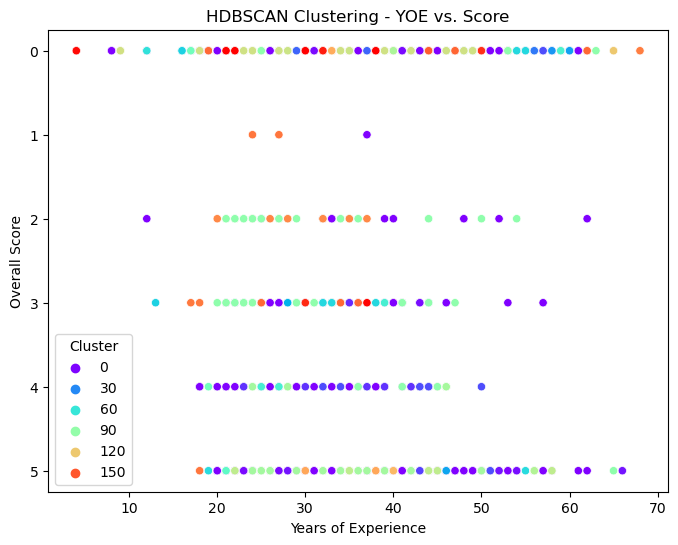

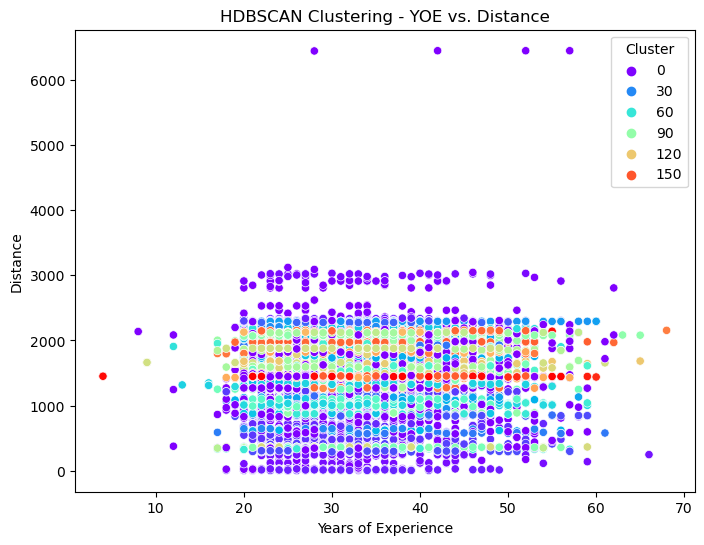

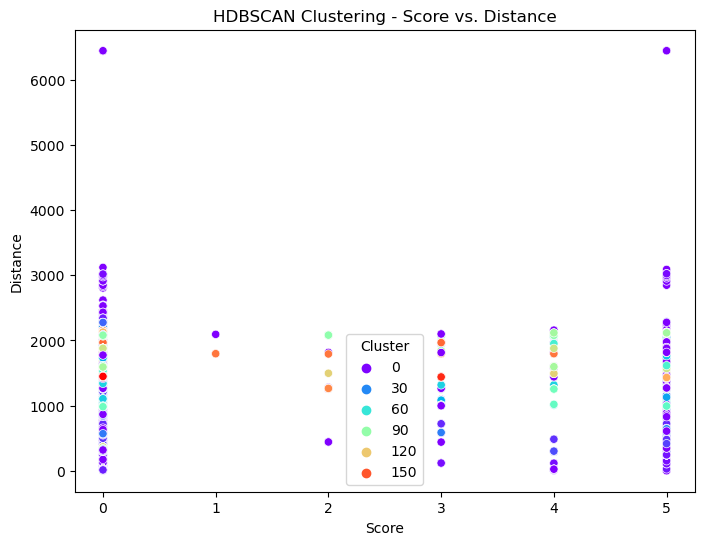

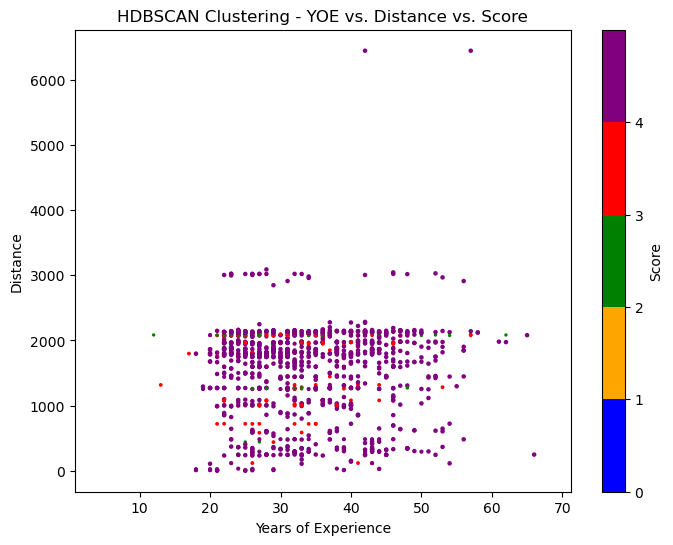

,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
3313,"KHATTAB, MAZEN",M,25,OTHER,AMERICAN ONCOLOGY PARTNERS PA,(623) 265-7215,"2925 W ROSE GARDEN LN STE 110, PHOENIX, AZ 85027",1.7,5
16149,"WINGO, SHANA N",F,21,UNIVERSITY OF TEXAS SOUTHWESTERN MEDICAL SCHOO...,AMERICAN ONCOLOGY PARTNERS PA,(623) 265-7215,"2925 W ROSE GARDEN LN STE 110, PHOENIX, AZ 85027",1.7,5
2690,"PATEL, MUKUNDKUMAR V",M,37,OTHER,"HONORHEALTH MEDICAL GROUP, LLC",(855) 485-4673,"19646 N 27TH AVE STE 301, PHOENIX, AZ 85027",1.8,0
9000,"LEE, HENRY K",M,34,ILLINOIS MEDICAL COLLEGE,"HONORHEALTH MEDICAL GROUP, LLC",(855) 485-4673,"19646 N 27TH AVE STE 301, PHOENIX, AZ 85027",1.8,0
5167,"BERGSAGEL, PETER L",M,39,OTHER,MAYO CLINIC - ARIZONA,(480) 301-8000,"13400 E SHEA BLVD, SCOTTSDALE, AZ 85259",18.4,0


In [109]:
hdbscan_get_best_doctors(df, 85027, priority=['distance','score','experience'], unique_doctors=True, show_plots=True)

94015 coordinates: (37.6813125, -122.4806336)
Number of clusters formed: 179
Cluster(s) chosen: [-1]


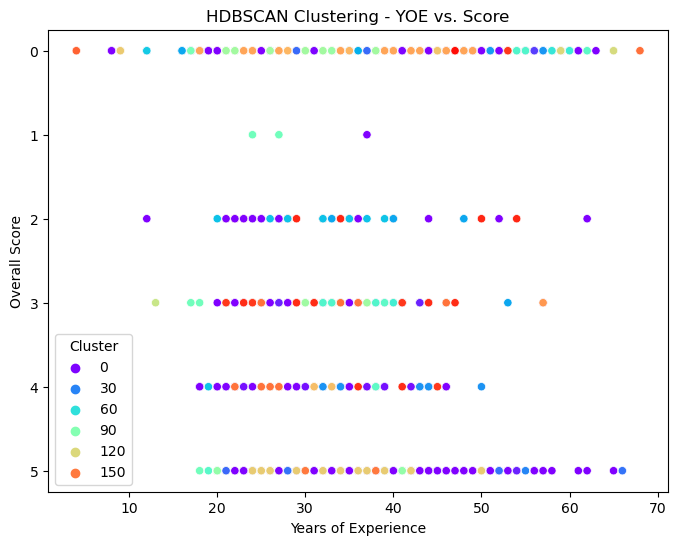

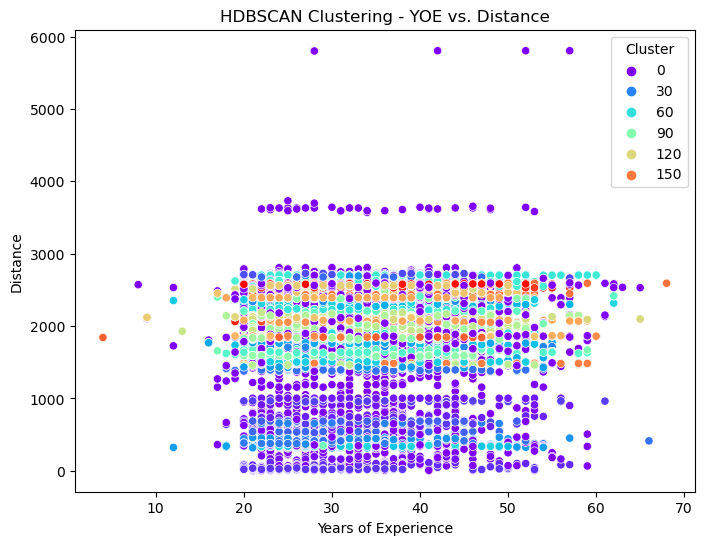

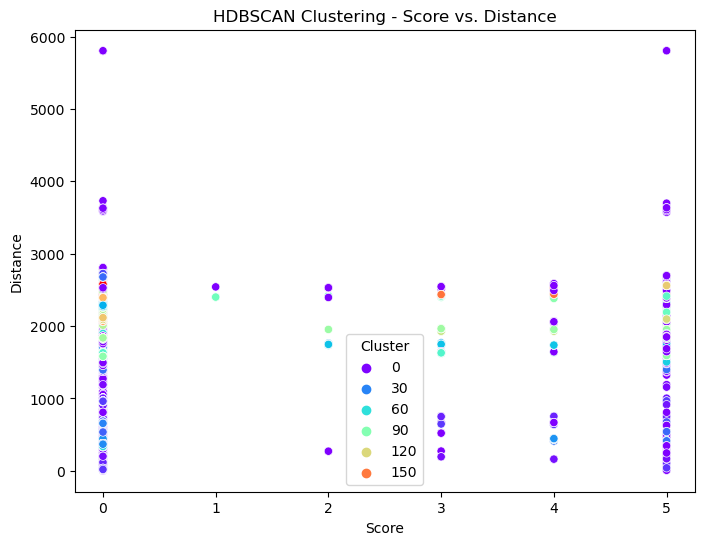

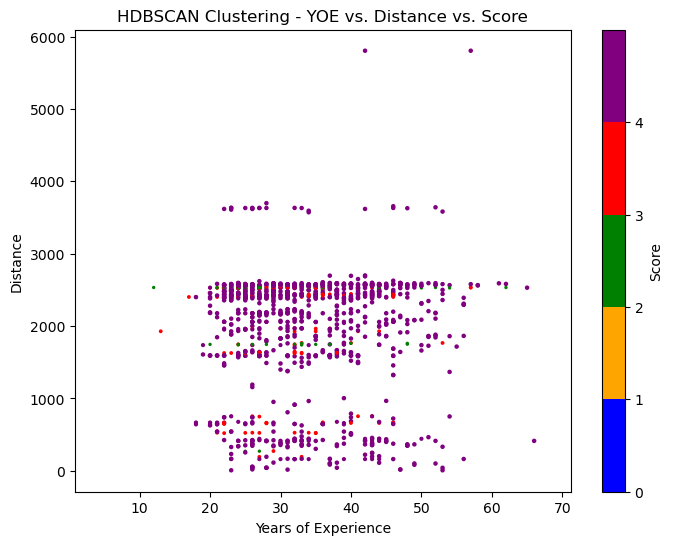

,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
4148,"WU, MEIWEN",F,41,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",0.4,0
3932,"RAJPAL, SUPRIYA",F,23,OTHER,PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",2.7,0
6618,"KAO, SUSAN YU-SHAN",F,21,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO SCHOOL...",PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",2.7,0
3045,"MILLENDER, LAURA ELLEN",F,22,OTHER,PERMANENTE MEDICAL GROUP INC,(650) 827-6500,"220 OYSTER PT BLVD, S SAN FRANCISCO, CA 94080",5.1,0
2588,"NIEMI, SACHA ZULEIKA",F,23,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,MY HEALTH MEDICAL GROUP INC,(415) 550-0811,"1580 VALENCIA ST STE 201, SAN FRANCISCO, CA 94110",5.6,0


In [110]:
hdbscan_get_best_doctors(df, 94015, priority=['distance','score','experience'], unique_doctors=True, show_plots=True)

In [111]:
hdbscan_get_best_doctors(df, 94044, priority=['distance','score','experience'], unique_doctors=True)

94044 coordinates: (37.6065981, -122.4772305)
Number of clusters formed: 175
Cluster(s) chosen: [-1]


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
2587,"NIEMI, SACHA ZULEIKA",F,23,ALBANY MEDICAL COLLEGE OF UNION UNIVERSITY,UNKNOWN,(317) 413-4936,"751 SAN PEDRO TER RD, PACIFICA, CA 94044",1.8,5
3932,"RAJPAL, SUPRIYA",F,23,OTHER,PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",4.2,0
6618,"KAO, SUSAN YU-SHAN",F,21,"UNIVERSITY OF CALIFORNIA, SAN FRANCISCO SCHOOL...",PERMANENTE MEDICAL GROUP INC,(650) 742-2000,"1200 EL CAMINO REAL, S SAN FRANCISCO, CA 94080",4.2,0
7806,"MARGOLIS, MICHAEL T",M,36,UNIVERSITY OF KANSAS SCHOOL OF MED (KC/WICH/SAL),BAYCHILDRENS,(650) 239-5303,"1820 OGDEN DR, BURLINGAME, CA 94010",5.0,0
4148,"WU, MEIWEN",F,41,OTHER,NORTHERN CALIFORNIA RADIATION THERAPISTS AND O...,(650) 991-6726,"1900 SULLIVAN AVE, DALY CITY, CA 94015",5.1,0


In [112]:
hdbscan_get_best_doctors(df, 94608, priority=['distance','score','experience'], unique_doctors=True)

94608 coordinates: (37.8368441, -122.2891434)
Number of clusters formed: 174
Cluster(s) chosen: [-1]


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
8740,"NIAZ, QAISER",M,27,OTHER,EPIC CARE,(510) 629-6682,"1480 64TH ST STE 100, EMERYVILLE, CA 94608",0.6,0
11171,"ABRAMS, DONALD I",M,46,STANFORD UNIVERSITY SCHOOL OF MEDICINE,UCSF MEDICAL GROUP BUSINESS SERVICES,(510) 985-5020,"3100 SAN PABLO AVE, BERKELEY, CA 94702",0.9,0
7172,"SMALL, ERIC J",M,38,CLVLND CLINIC LERNER COLLEGE OF MED OF CASE WS...,UCSF MEDICAL GROUP BUSINESS SERVICES,(510) 985-5020,"3100 SAN PABLO AVE, BERKELEY, CA 94702",0.9,0
8808,"EKSTRAND, BRADLEY C",M,26,YALE UNIVERSITY SCHOOL OF MEDICINE,UCSF MEDICAL GROUP BUSINESS SERVICES,(510) 985-5020,"3100 SAN PABLO AVE, BERKELEY, CA 94702",0.9,0
12471,"BROWN, JENNIFER A",F,24,RUSH MEDICAL COLLEGE OF RUSH UNIVERSITY,UCSF MEDICAL GROUP BUSINESS SERVICES,(510) 985-5020,"3100 SAN PABLO AVE, BERKELEY, CA 94702",0.9,0


In [113]:
hdbscan_get_best_doctors(df, 94608, priority=['score','distance','experience'], unique_doctors=True)

94608 coordinates: (37.8368441, -122.2891434)
Number of clusters formed: 174
Cluster(s) chosen: [-1]


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
15405,"REIER, ALICE",F,31,MEDICAL COLLEGE OF WISCONSIN,UNKNOWN,(510) 834-3700,"3300 WEBSTER ST STE 900, OAKLAND, CA 94609",1.8,5
7287,"STERN, JEFFREY",M,47,STATE UNIVERSITY OF NY UPSTATE MEDICAL UNIVERSITY,UNKNOWN,missing,"2500 MILVIA ST STE 224, BERKLEY, CA 94704",2.1,5
9856,"JEYAPALAN-NOONE, MANJULA MAYURA",F,28,"UNIVERSITY OF IOWA, RJ & L CARVER COLLEGE OF M...",UNKNOWN,(408) 378-6131,"815 POLLARD RD, LOS GATOS, CA 95032",43.3,5
1888,"BUI, LYNNE AI",F,26,"UNIVERSITY OF CALIFORNIA, GEFFEN SCHOOL OF MED...",UNKNOWN,(408) 384-9284,"14651 S BASCOM AVE STE 112, LOS GATOS, CA 95032",44.2,5
9955,"BASTIDAS, JEFFERSON A",M,38,UNIVERSITY OF CINCINNATI COLLEGE OF MEDICINE,UNKNOWN,(408) 358-4747,"14981 NATIONAL AVE STE 4, LOS GATOS, CA 95032",44.5,5


In [114]:
hdbscan_get_best_doctors(df, 94608, priority=['score','distance'], unique_doctors=True)

94608 coordinates: (37.8368441, -122.2891434)
Number of clusters formed: 174
Cluster(s) chosen: [-1]


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
15405,"REIER, ALICE",F,31,MEDICAL COLLEGE OF WISCONSIN,UNKNOWN,(510) 834-3700,"3300 WEBSTER ST STE 900, OAKLAND, CA 94609",1.8,5
7287,"STERN, JEFFREY",M,47,STATE UNIVERSITY OF NY UPSTATE MEDICAL UNIVERSITY,UNKNOWN,missing,"2500 MILVIA ST STE 224, BERKLEY, CA 94704",2.1,5
9856,"JEYAPALAN-NOONE, MANJULA MAYURA",F,28,"UNIVERSITY OF IOWA, RJ & L CARVER COLLEGE OF M...",UNKNOWN,(408) 378-6131,"815 POLLARD RD, LOS GATOS, CA 95032",43.3,5
1888,"BUI, LYNNE AI",F,26,"UNIVERSITY OF CALIFORNIA, GEFFEN SCHOOL OF MED...",UNKNOWN,(408) 384-9284,"14651 S BASCOM AVE STE 112, LOS GATOS, CA 95032",44.2,5
9955,"BASTIDAS, JEFFERSON A",M,38,UNIVERSITY OF CINCINNATI COLLEGE OF MEDICINE,UNKNOWN,(408) 358-4747,"14981 NATIONAL AVE STE 4, LOS GATOS, CA 95032",44.5,5


In [115]:
hdbscan_get_best_doctors(df, 85027, priority=['distance','score','experience'], unique_doctors=True)

85027 coordinates: (33.6797612, -112.0925291)
Number of clusters formed: 170
Cluster(s) chosen: [-1]


,Oncologist Name,Gender,Years of Experience,Medical School,Org Name,Phone Number,Address,Distance (miles),Score
3313,"KHATTAB, MAZEN",M,25,OTHER,AMERICAN ONCOLOGY PARTNERS PA,(623) 265-7215,"2925 W ROSE GARDEN LN STE 110, PHOENIX, AZ 85027",1.7,5
16149,"WINGO, SHANA N",F,21,UNIVERSITY OF TEXAS SOUTHWESTERN MEDICAL SCHOO...,AMERICAN ONCOLOGY PARTNERS PA,(623) 265-7215,"2925 W ROSE GARDEN LN STE 110, PHOENIX, AZ 85027",1.7,5
2690,"PATEL, MUKUNDKUMAR V",M,37,OTHER,"HONORHEALTH MEDICAL GROUP, LLC",(855) 485-4673,"19646 N 27TH AVE STE 301, PHOENIX, AZ 85027",1.8,0
9000,"LEE, HENRY K",M,34,ILLINOIS MEDICAL COLLEGE,"HONORHEALTH MEDICAL GROUP, LLC",(855) 485-4673,"19646 N 27TH AVE STE 301, PHOENIX, AZ 85027",1.8,0
5167,"BERGSAGEL, PETER L",M,39,OTHER,MAYO CLINIC - ARIZONA,(480) 301-8000,"13400 E SHEA BLVD, SCOTTSDALE, AZ 85259",18.4,0
